In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import imageio
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


# these lines are necessary for some reason, because otherwise the kernel keeps on dying when using matplotlib (on my machine at least)
import os    
import sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3> Importing the data

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

<h2> Model architecture - CNN

In [4]:
# reference : https://adversarial-ml-tutorial.org/adversarial_examples/
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

<h3> Training

In [5]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [6]:
n_epochs = 10
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print("train_err\ttrain_loss\ttest_err\ttest_loss")
for t in range(n_epochs):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

train_err	train_loss	test_err	test_loss
0.272400	0.786964	0.040600	0.127243
0.026833	0.087837	0.023400	0.071578
0.016583	0.053981	0.021800	0.062222
0.011417	0.037955	0.017300	0.052364
0.008167	0.026874	0.016400	0.048166
0.004467	0.015498	0.011300	0.036421
0.003417	0.011960	0.011200	0.037182
0.002817	0.010399	0.011200	0.038024
0.002400	0.009284	0.011200	0.038847
0.002050	0.008377	0.011200	0.039604


<h2> Model performance

In [7]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model_cnn, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[ 974    0    0    0    0    1    2    1    2    0]
 [   0 1130    0    1    0    0    2    0    2    0]
 [   1    1 1020    1    1    0    1    4    3    0]
 [   0    0    1 1000    0    3    0    0    3    3]
 [   0    0    2    0  975    0    1    0    0    4]
 [   2    0    0    4    0  881    1    0    2    2]
 [   3    2    0    1    4    5  942    0    1    0]
 [   1    2    3    1    0    0    0 1018    1    2]
 [   5    0    1    2    2    1    1    2  959    1]
 [   1    2    0    0    8    4    0    4    1  989]]
Accuracy score: 0.988800


<h2> Original data visualized

In [8]:
# some illustrating examples
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N, class_title=None):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    if class_title is not None:
        f.suptitle("Target class " + str(class_title))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

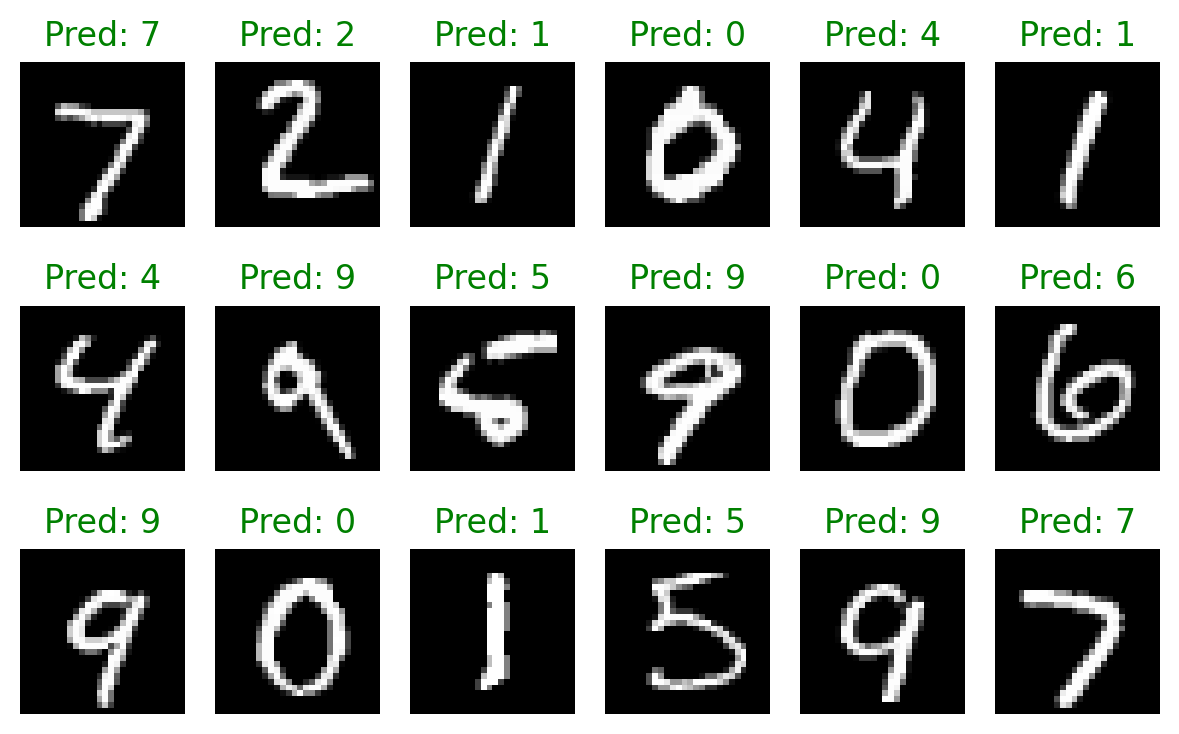

In [9]:
### Illustrate original predictions
y_pred = model_cnn(X)
plot_images(X, y, y_pred, 3, 6)

<h2> targeted FGSM

In [10]:
# based on an image X and target_label tensor, determine the perturbation based on fgsm
# based on above reference, adjusted to make it targeted

def fgsm(model, X, target_label, epsilon):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), target_label)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

percentage classified as target class 2: 0.57
percentage classified as target class 3: 0.75
percentage classified as target class 5: 0.68
percentage classified as target class 8: 0.81
percentage classified as target class 9: 0.78


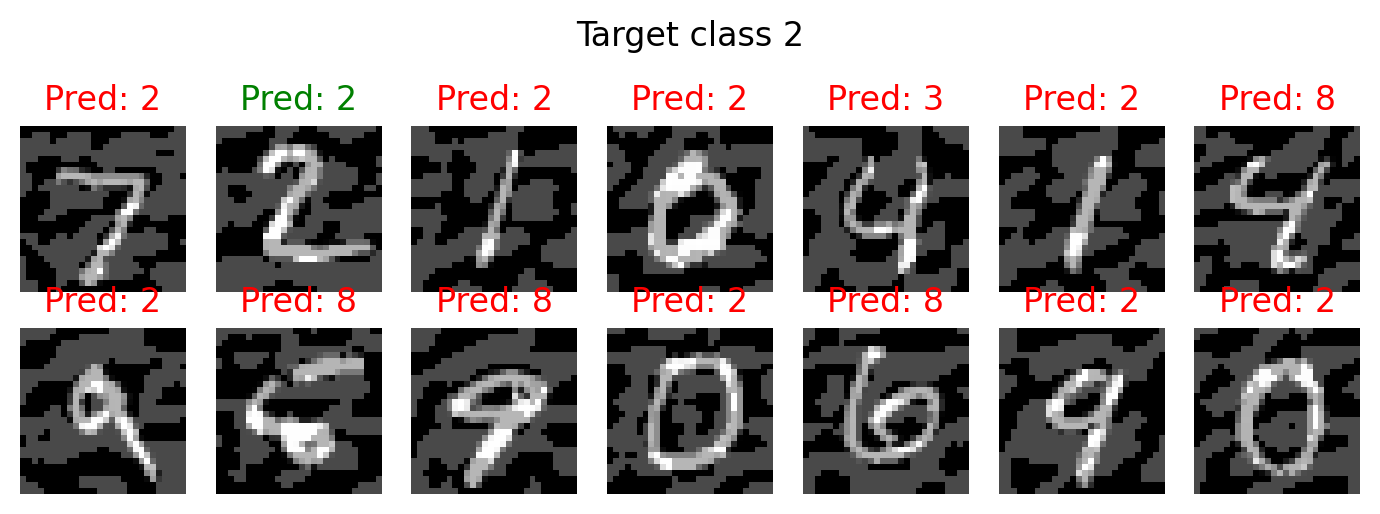

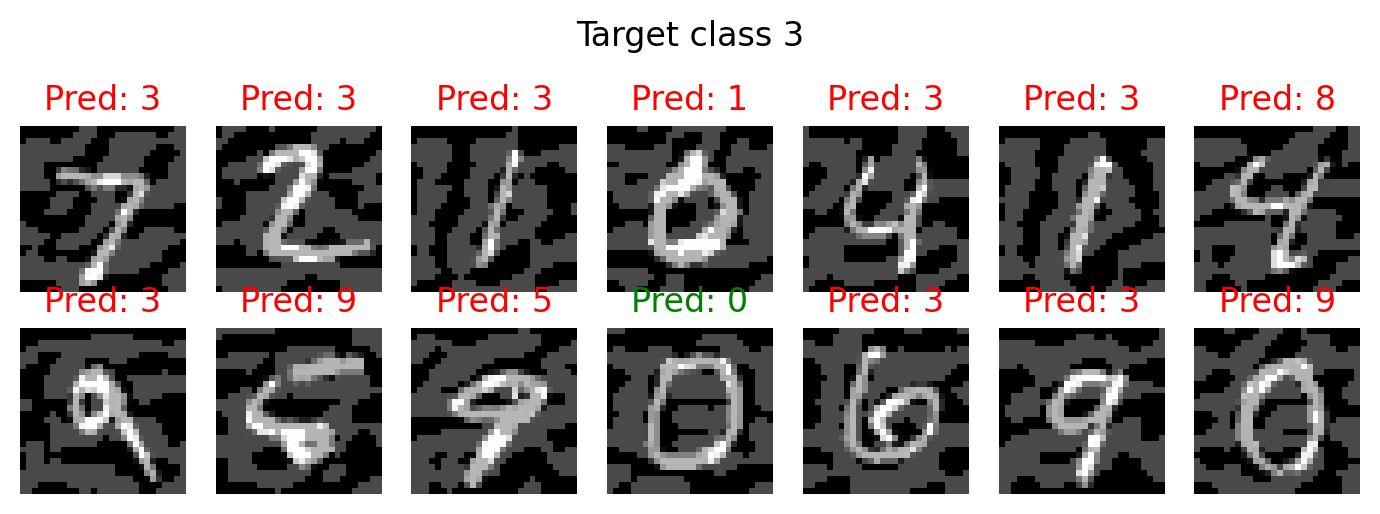

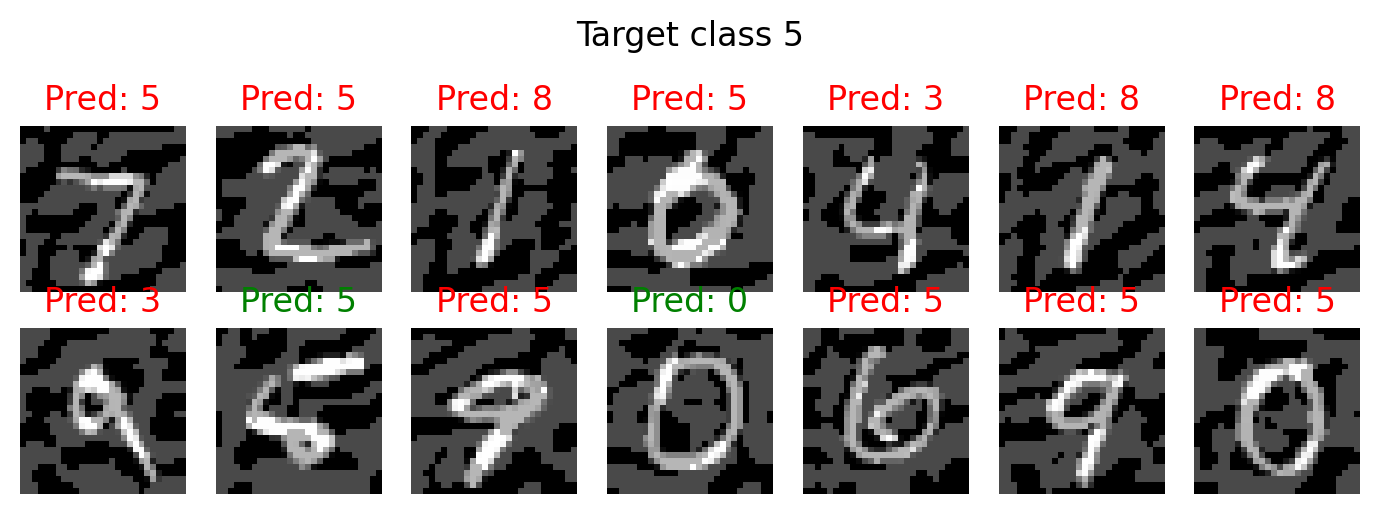

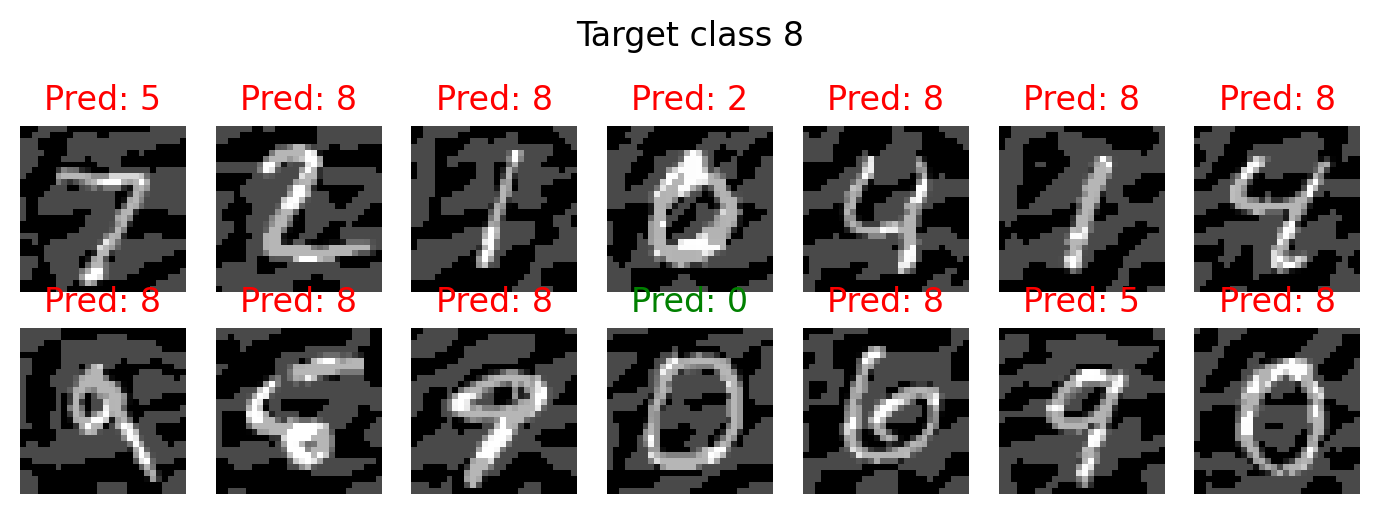

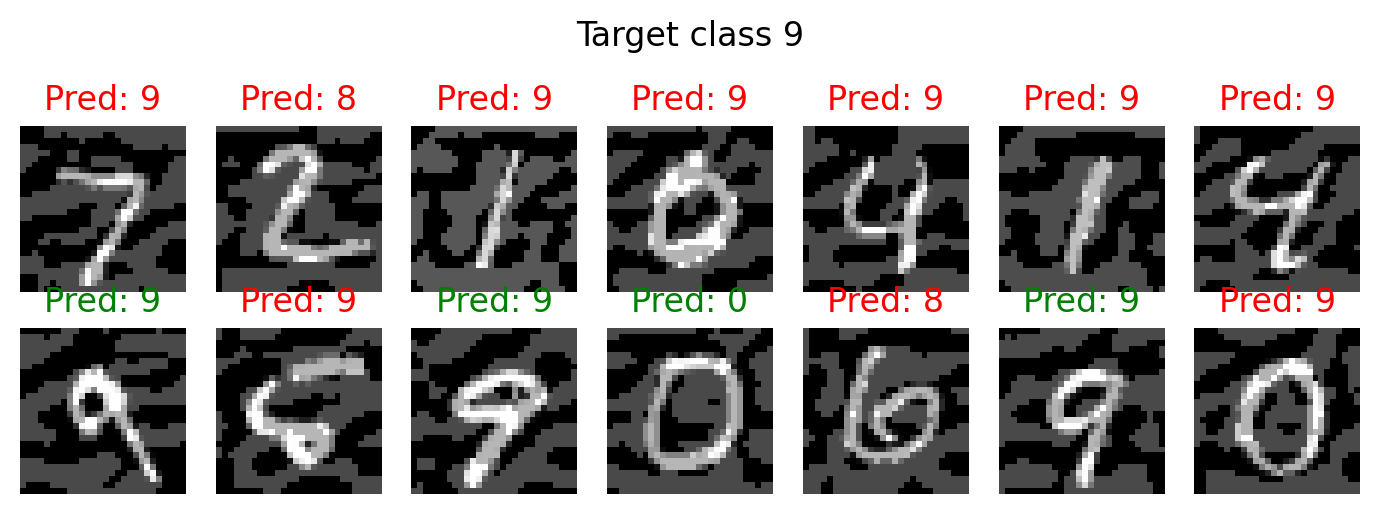

In [11]:
target_classes = [2,3,5,8,9]
for number in target_classes:
    # create a tensor filled with the target label
    target_label = torch.full((100,), number).to(device)
    delta = fgsm(model_cnn, X, target_label, 0.2)
    # prediction of attacked images
    yp = model_cnn(X - delta)
    # plot some example images per targeted attack
    plot_images(X-delta, y, yp, 2, 7, class_title=number)
    print("percentage classified as target class " +str(number) +  ": " + str([s.argmax().item() for s in yp].count(number)/100))


<h2> PGD targeted attack

In [12]:
# based on above reference
def pgd_attack(model, X, y, epsilon, alpha, num_iter, target_label):

    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,target_label] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

percentage classified as target class 2: 0.72
percentage classified as target class 3: 0.8
percentage classified as target class 5: 0.79
percentage classified as target class 8: 0.84
percentage classified as target class 9: 0.8


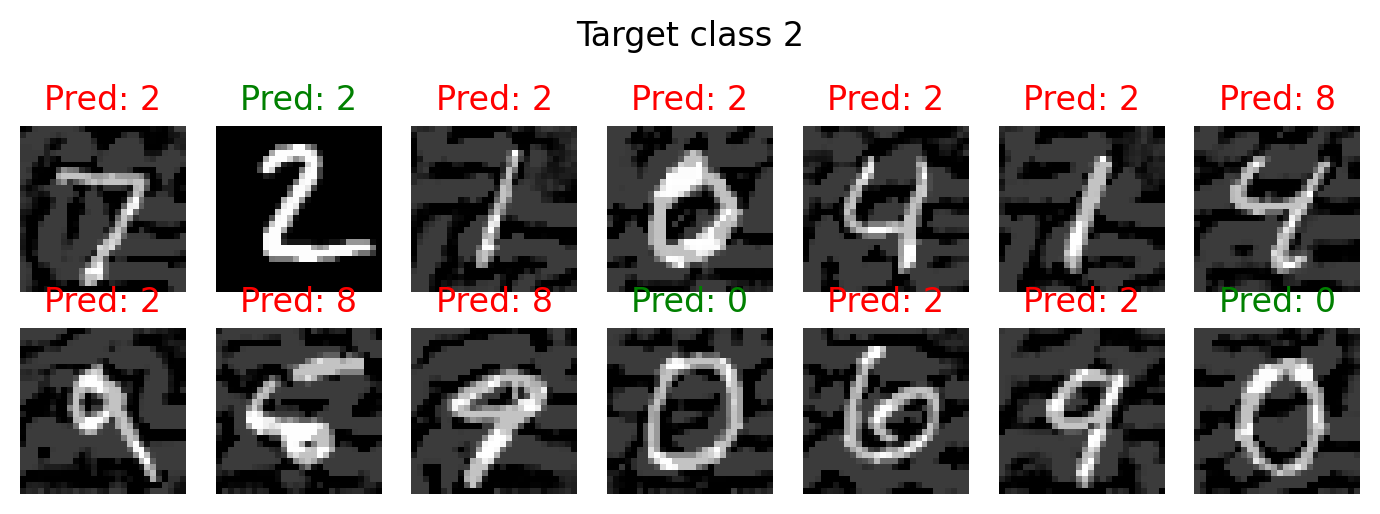

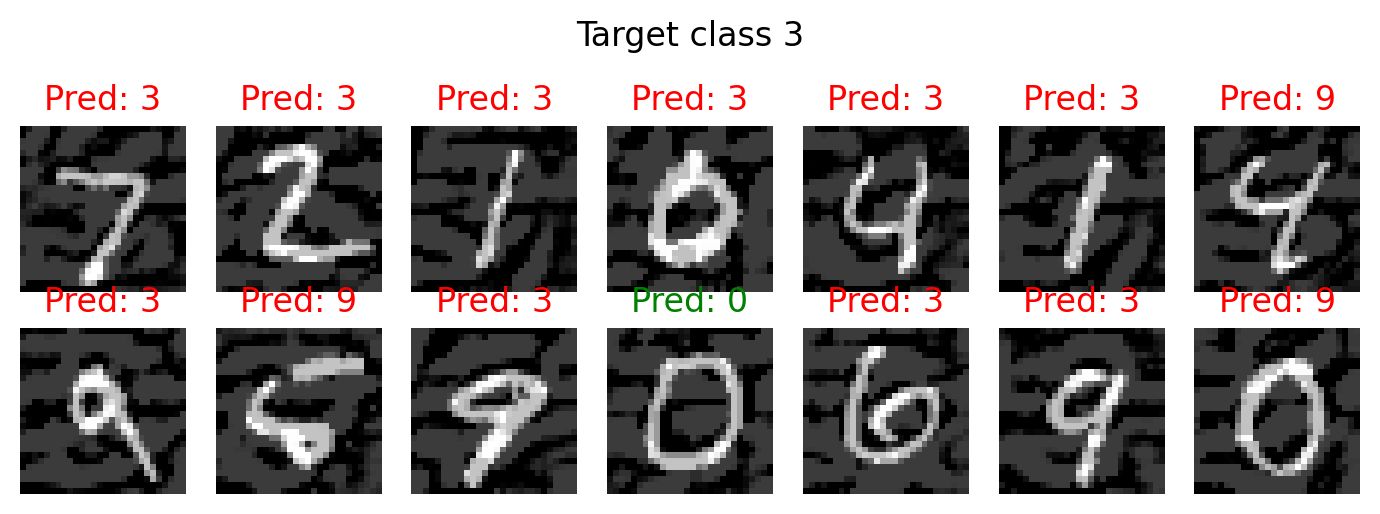

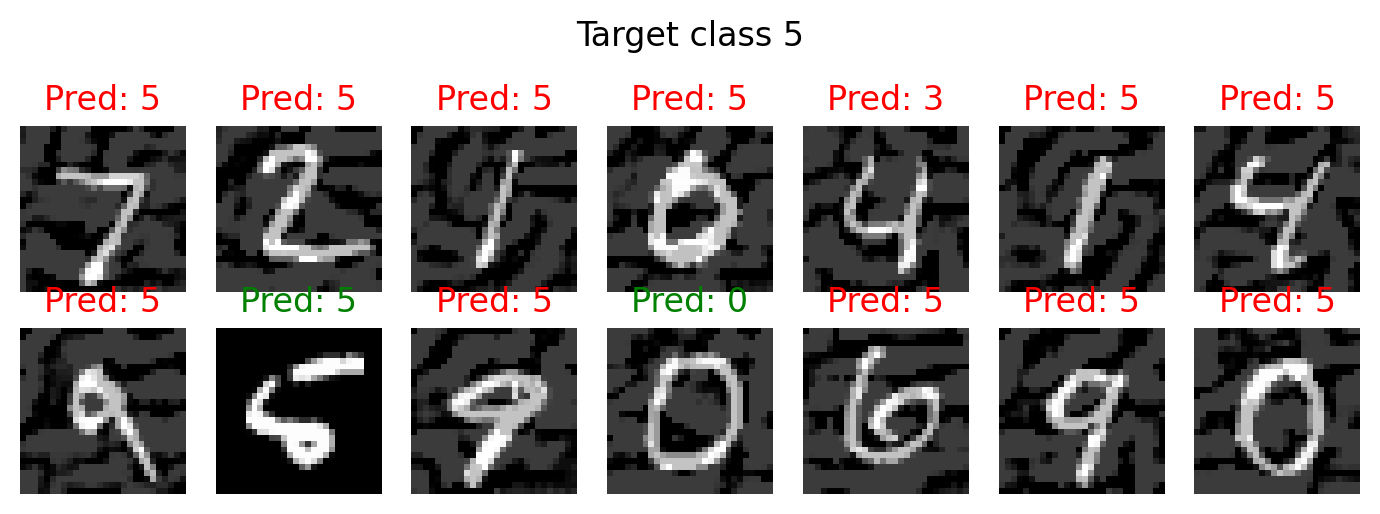

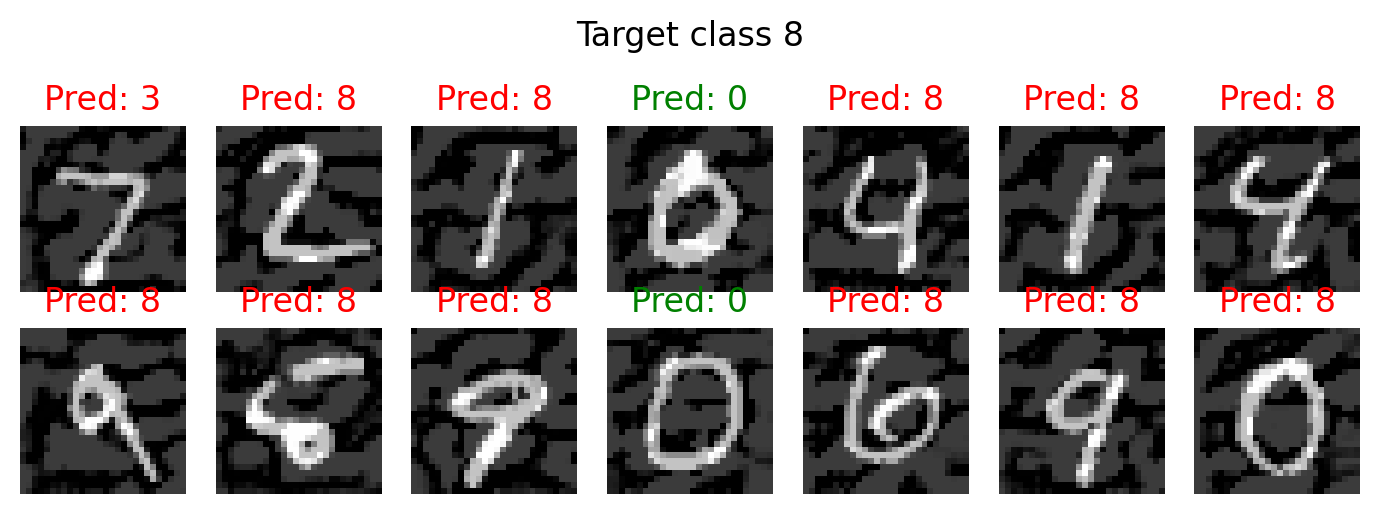

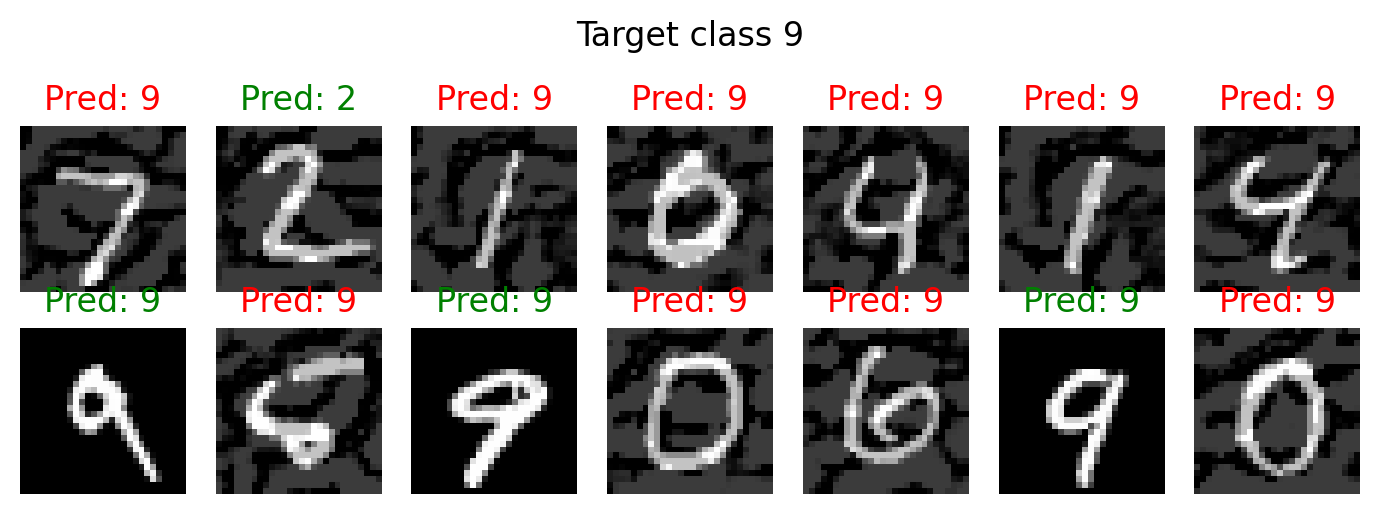

In [13]:
# perform a targeted attack to 5 different classes 
test_classes = [2,3,5,8,9]
for number in test_classes:
    delta = pgd_attack(model_cnn, X, y, epsilon=0.15, alpha=1e-2, num_iter=40, target_label=number)
    yp = model_cnn(X + delta)
    print("percentage classified as target class " +str(number) +  ": " + str([s.argmax().item() for s in yp].count(number)/100))

    plot_images(X+delta, y, yp, 2, 7, class_title= number)

<h2> Iterative FGSM

In [14]:
# reference: https://github.com/Harry24k/AEPW-pytorch/blob/master/Adversarial%20examples%20in%20the%20physical%20world.ipynb
def basic_iterative_attack(model, loss, images, labels, scale, eps, alpha, iters=0) :
    # send images and labels to device
    images = images.to(device)
    labels = labels.to(device)
    # limit for later scaling
    clamp_max = 28
    
    if iters == 0 :
        iters = int(min(eps + 4, 1.25*eps))
              
    # if scale == 1 scale down epsilon and set clamp_max to 1,[image values are between 0 and 1] 
    if scale :
        eps = eps / 28
        clamp_max = clamp_max / 28
        
    for i in range(iters) :    
        images.requires_grad = True
        # get the predictions of the current images
        outputs = model(images)

        # reset gradient and compute the loss between predictions and target_labels
        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()
        # adjust the images
        attack_images = images - alpha*images.grad.sign()
        # scale image into desired interval [0,1]
        a = torch.clamp(images - eps, min=0)
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        images = torch.clamp(c, max=clamp_max).detach_()
            
    return images

percentage classified as target class 2: 0.42
percentage classified as target class 3: 0.57
percentage classified as target class 5: 0.47
percentage classified as target class 8: 0.51
percentage classified as target class 9: 0.5


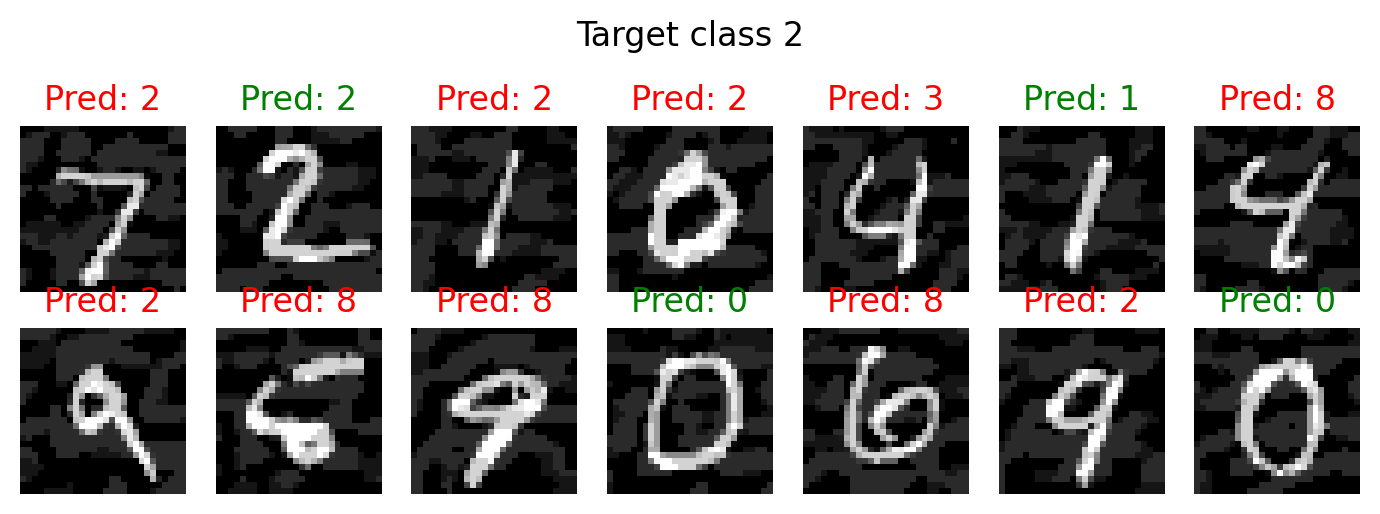

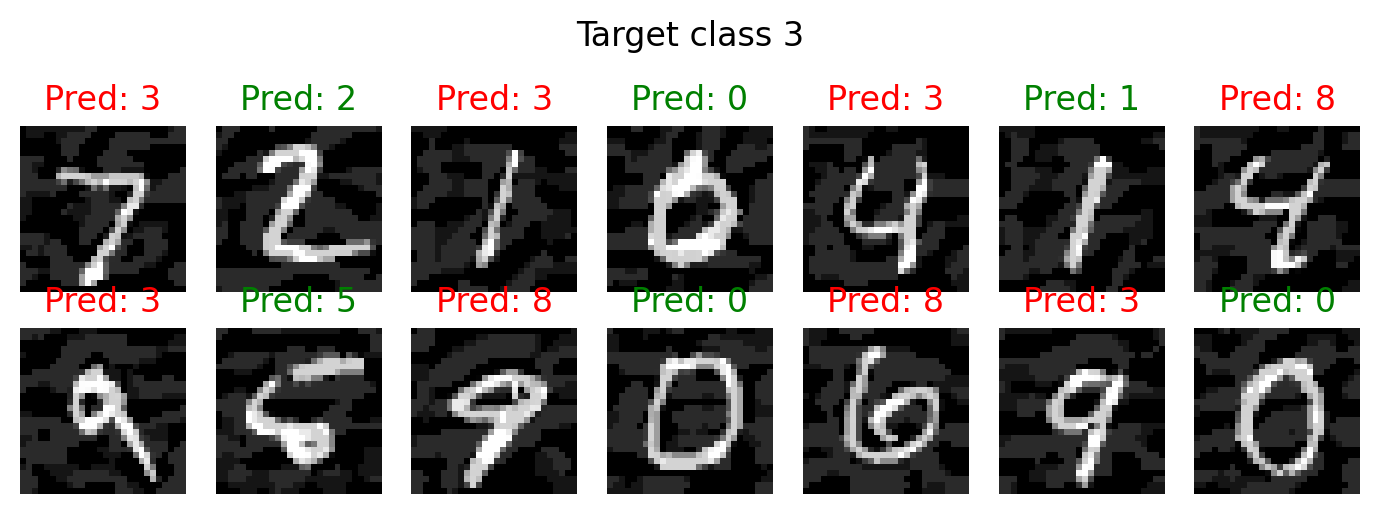

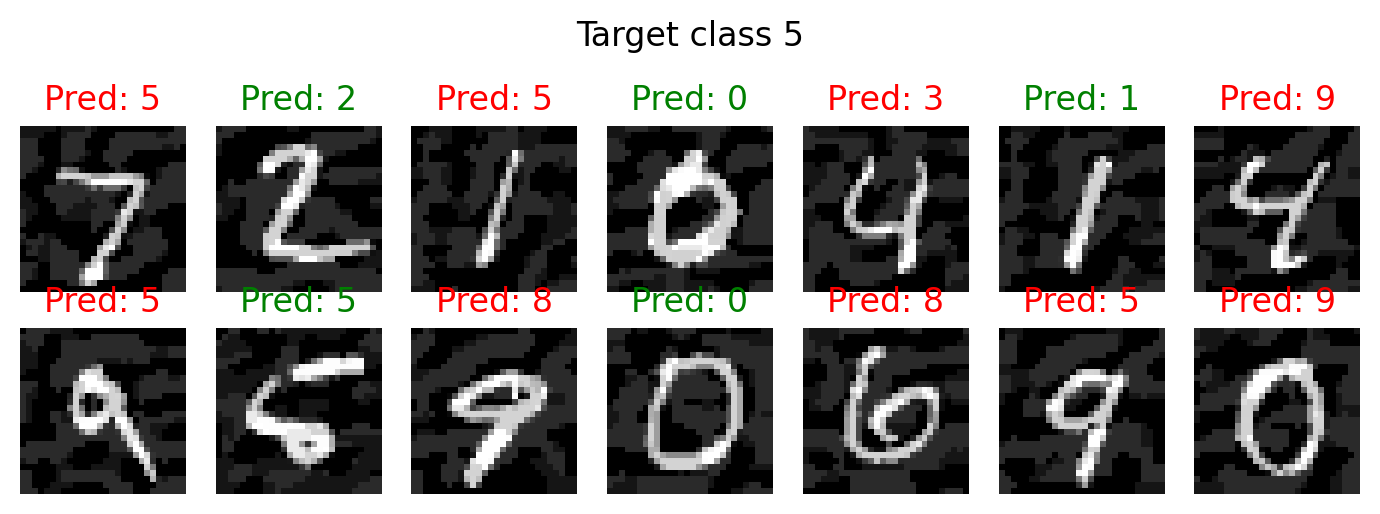

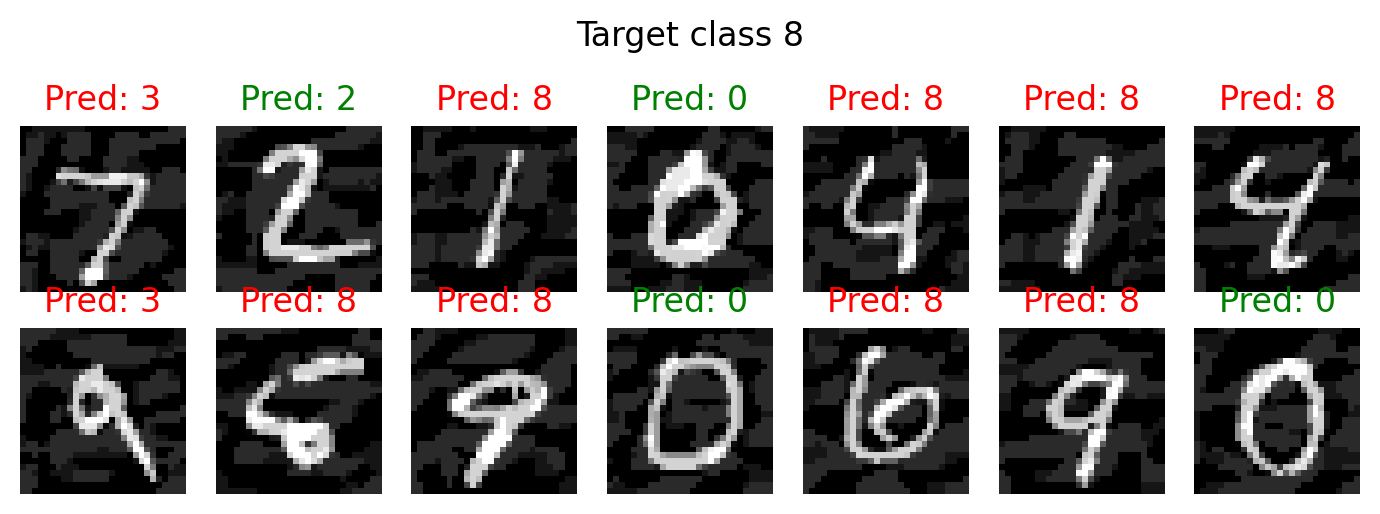

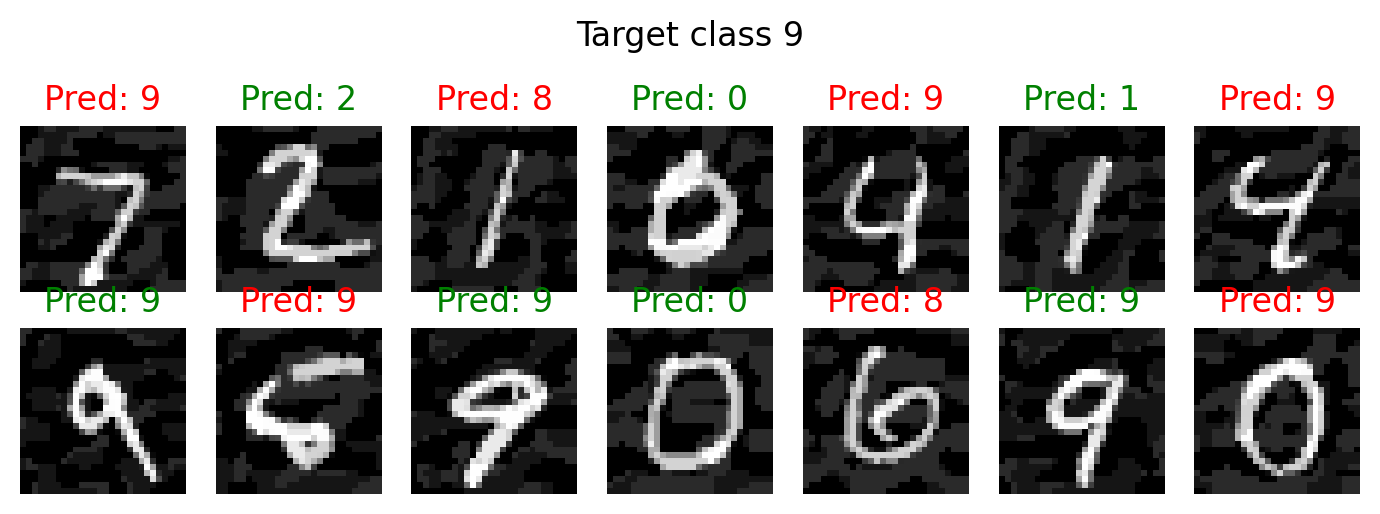

In [15]:
model_cnn.eval()
loss = nn.CrossEntropyLoss()

correct = 0
total = 0
scale = 1
alpha = 1
eps = 2.3

# perform targeted attack on 5 different classes
test_classes = [2,3,5,8,9]
for number in test_classes:
    
    target_label = torch.full((100,), number).to(device)
    adv_images = basic_iterative_attack(model_cnn, loss, X, target_label, scale, eps, alpha).to(device)
    
    yp = model_cnn(adv_images)
    print("percentage classified as target class " +str(number) +  ": " + str([s.argmax().item() for s in yp].count(number)/100))

    plot_images(adv_images, y, yp, 2, 7, class_title=number)


<h2> Exercise 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

<h2> First model architecture - CNN

In [17]:
# model and training code taken from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [18]:
# load fashion MNIST data
transform = transforms.Compose([
        transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root = '/data/fashion/', train = True, download = True, transform = transform)
fashion_train_dataloader = torch.utils.data.DataLoader(trainset, batch_size = 100, shuffle = True)
    
testset = torchvision.datasets.FashionMNIST(root = "../uaps/fashion/", train = False, download = True, transform = transform)
fashion_test_dataloader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle = True)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

<h3> Train the model

In [19]:
model_fashion = FashionCNN()
model_fashion.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model_fashion.parameters(), lr=learning_rate)

In [20]:
num_epochs = 10
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in fashion_train_dataloader:
    
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model_fashion(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in fashion_test_dataloader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model_fashion(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.30529657006263733, Accuracy: 86.77999877929688%
Iteration: 1000, Loss: 0.217744842171669, Accuracy: 88.86000061035156%
Iteration: 1500, Loss: 0.3636073172092438, Accuracy: 90.06999969482422%
Iteration: 2000, Loss: 0.18970900774002075, Accuracy: 90.25999450683594%
Iteration: 2500, Loss: 0.2483944296836853, Accuracy: 90.19999694824219%
Iteration: 3000, Loss: 0.17970167100429535, Accuracy: 90.58999633789062%
Iteration: 3500, Loss: 0.33552002906799316, Accuracy: 91.05999755859375%
Iteration: 4000, Loss: 0.13064435124397278, Accuracy: 91.18999481201172%
Iteration: 4500, Loss: 0.10833939909934998, Accuracy: 90.5%
Iteration: 5000, Loss: 0.16205669939517975, Accuracy: 90.54999542236328%
Iteration: 5500, Loss: 0.10882244259119034, Accuracy: 90.63999938964844%
Iteration: 6000, Loss: 0.14549726247787476, Accuracy: 90.68000030517578%


In [21]:
actuals, predictions = test_label_predictions(model_fashion, device, fashion_test_dataloader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[928   0   5   7   5   1  49   0   5   0]
 [  3 983   1   8   0   0   3   0   2   0]
 [ 28   1 800   6  71   1  92   0   1   0]
 [ 39   7   6 886  14   0  46   0   2   0]
 [  4   0  26  26 881   0  62   0   1   0]
 [  0   0   0   0   0 971   0  21   1   7]
 [174   1  28  22  61   0 706   0   8   0]
 [  0   0   0   0   0   2   0 984   0  14]
 [  3   1   1   3   0   1   4   2 985   0]
 [  0   0   0   0   0   4   1  34   0 961]]
Accuracy score: 0.908500


<h2> Universal Perturbation Attack using the Adversarial Robustness Toolbox

In [22]:
from art.attacks.evasion import UniversalPerturbation
from art.estimators.classification.pytorch import PyTorchClassifier

# we only use n_samples many samples, since doing it for all images would take for ever
n_samples = 100
#extract images and labels, then take only the first 100 of each
train_x, train_y = np.array([item[0].numpy() for item in trainset]), np.array([item[1] for item in trainset])
train_x = train_x[:n_samples]
train_y = train_y[:n_samples]
test_x, test_y = np.array([item[0].numpy() for item in testset]), np.array([item[1] for item in testset])
test_x = test_x[:n_samples]
test_y = test_y[:n_samples]


criterion = torch.nn.CrossEntropyLoss()
# create a PytorchClassifier from our network
art_model = PyTorchClassifier(model=model_fashion, loss=criterion, optimizer=optimizer, channels_first=True, input_shape=(1,28,28,), nb_classes=10, clip_values=(0,255))

# perform UniversalPerturbationAttacks using the carlini wagner attack -scheme
attack = UniversalPerturbation(classifier=art_model, attacker = "carlini")
# generate attacked images
x_train_attack = attack.generate(train_x)
x_test_attack = attack.generate(test_x)

predictions = art_model.predict(x_test_attack)

# get the single predicted labels
predicted_labels = np.array([np.argmax(pred) for pred in predictions])

print('Base model accuracy: ', np.sum(predicted_labels == test_y) / len(test_y))

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Base model accuracy:  0.16


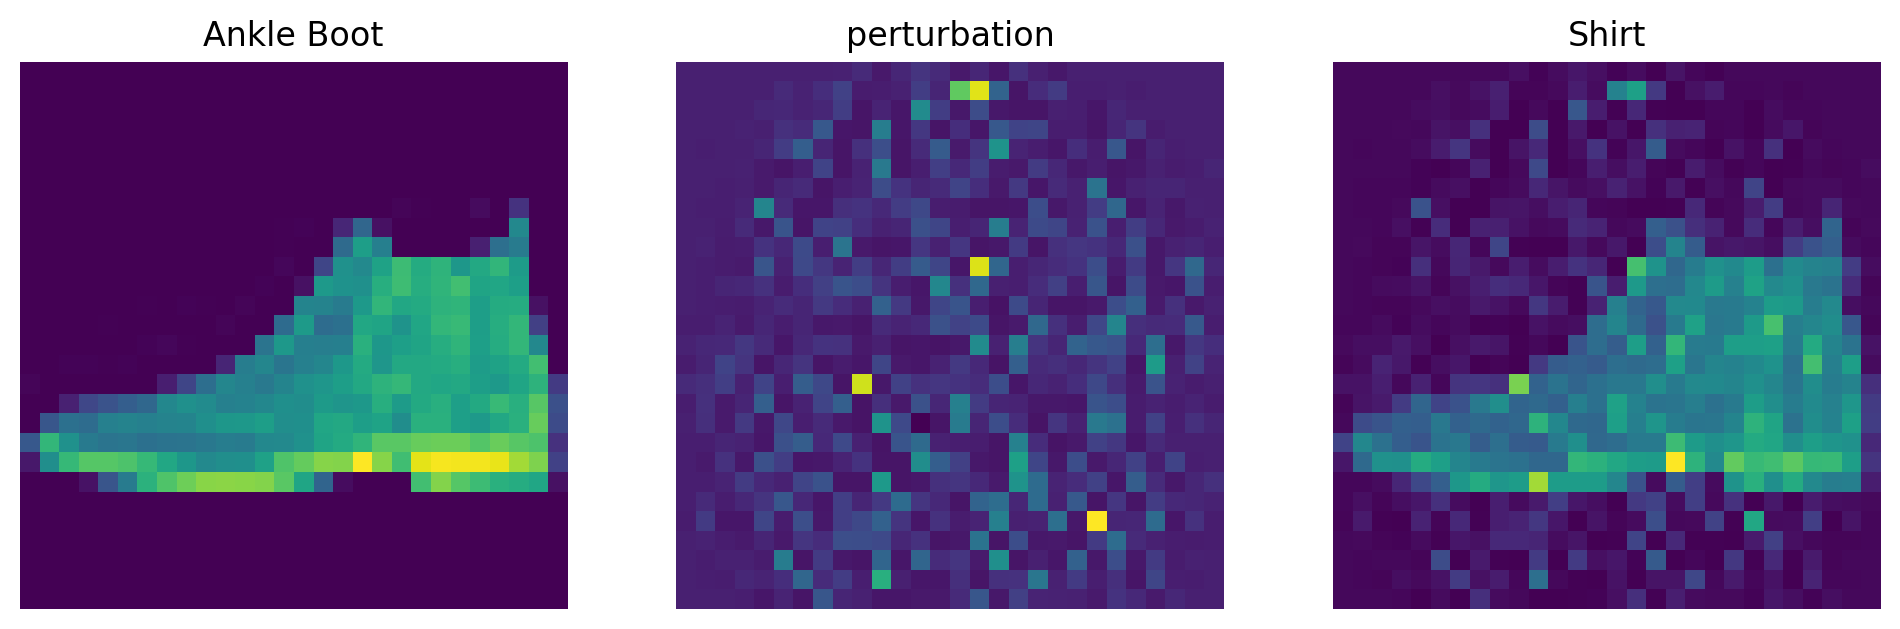

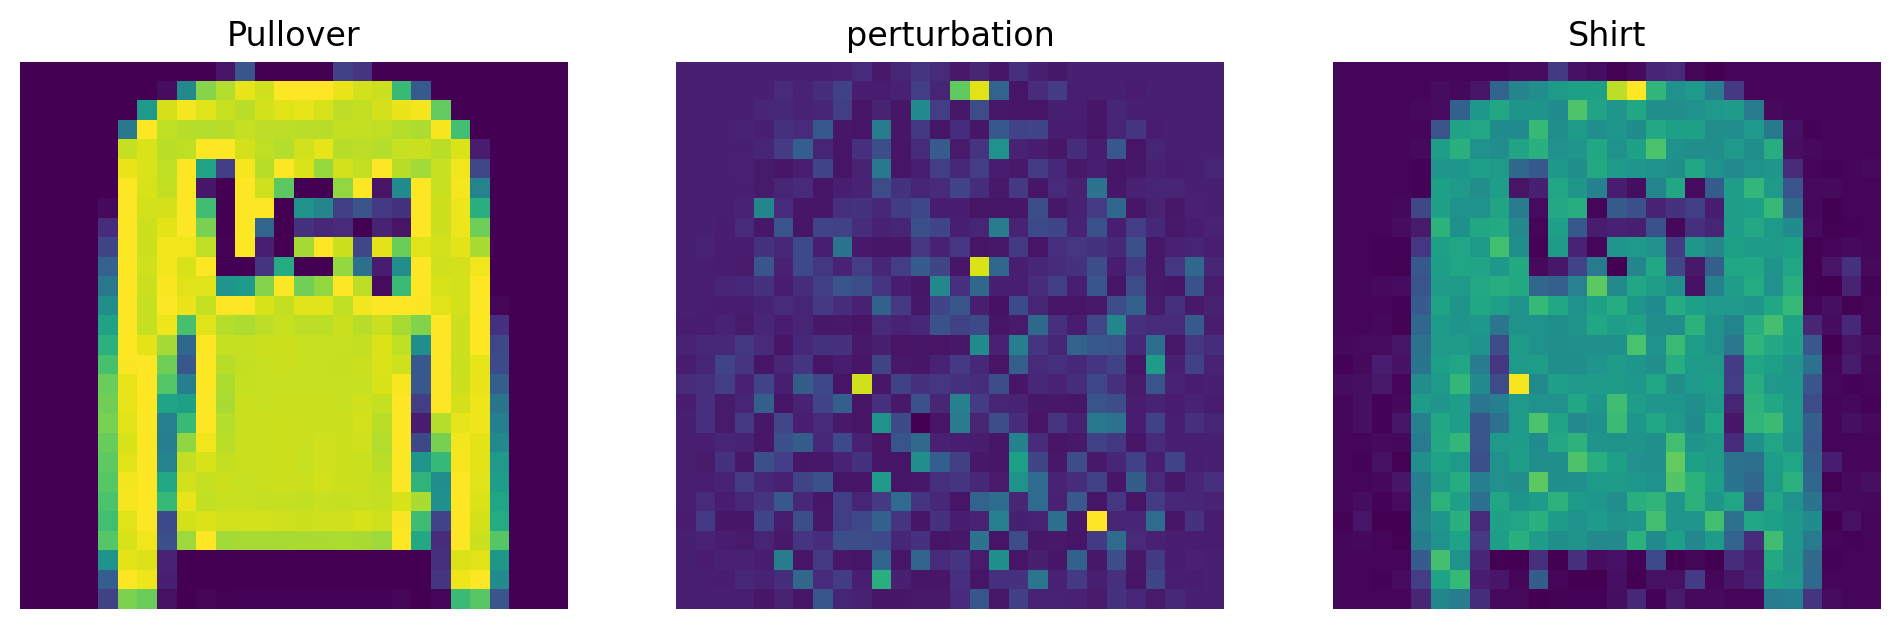

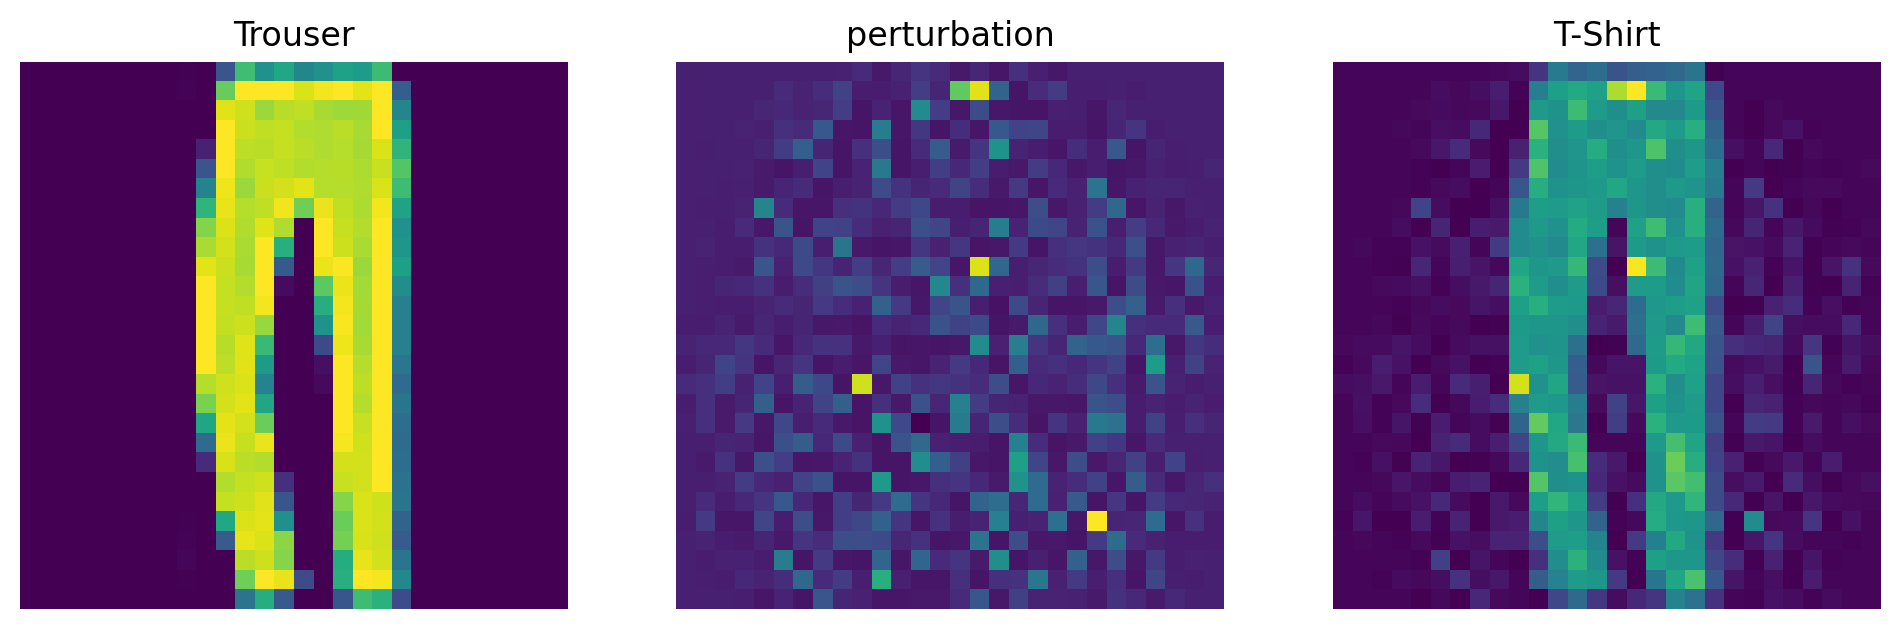

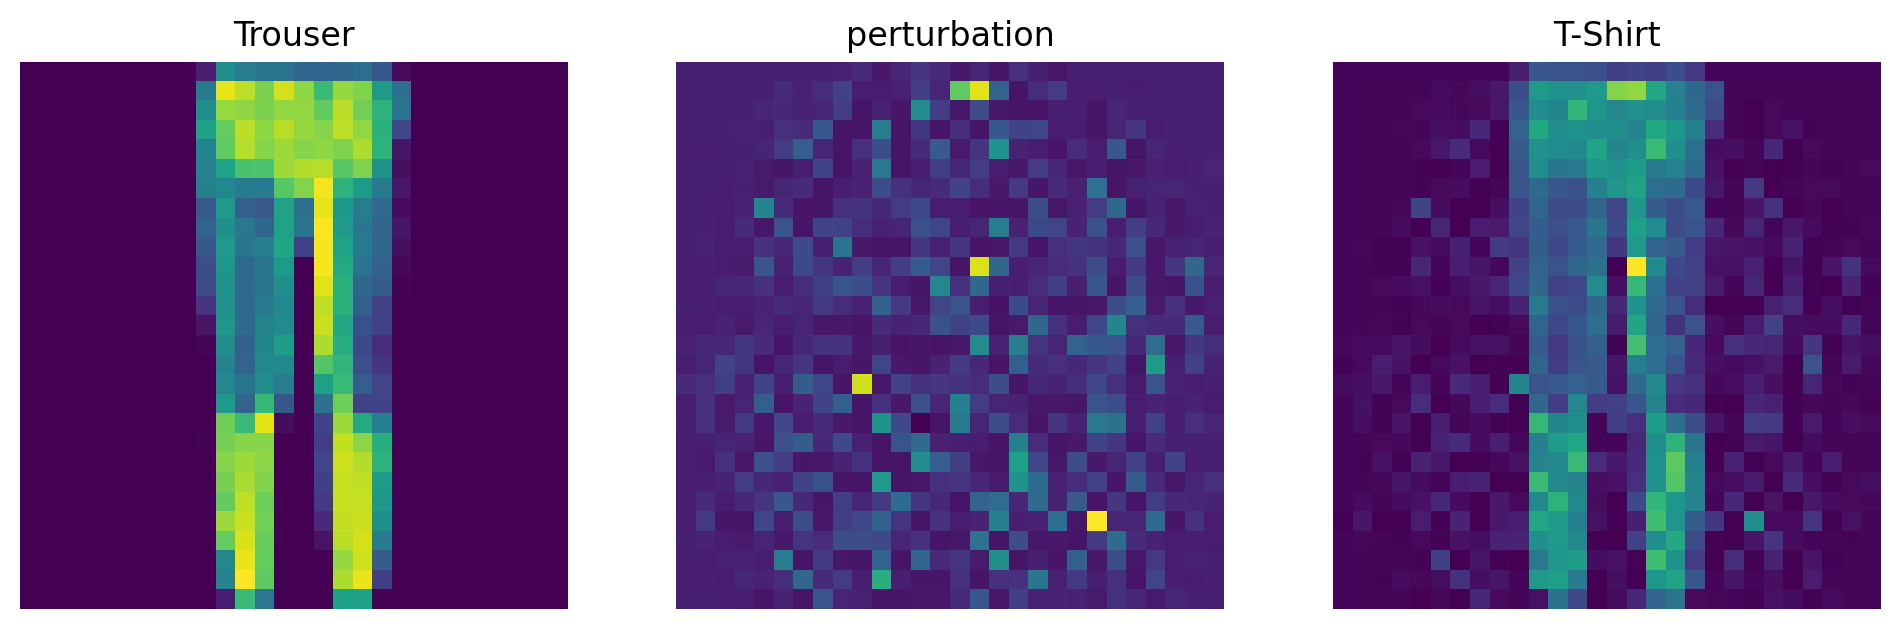

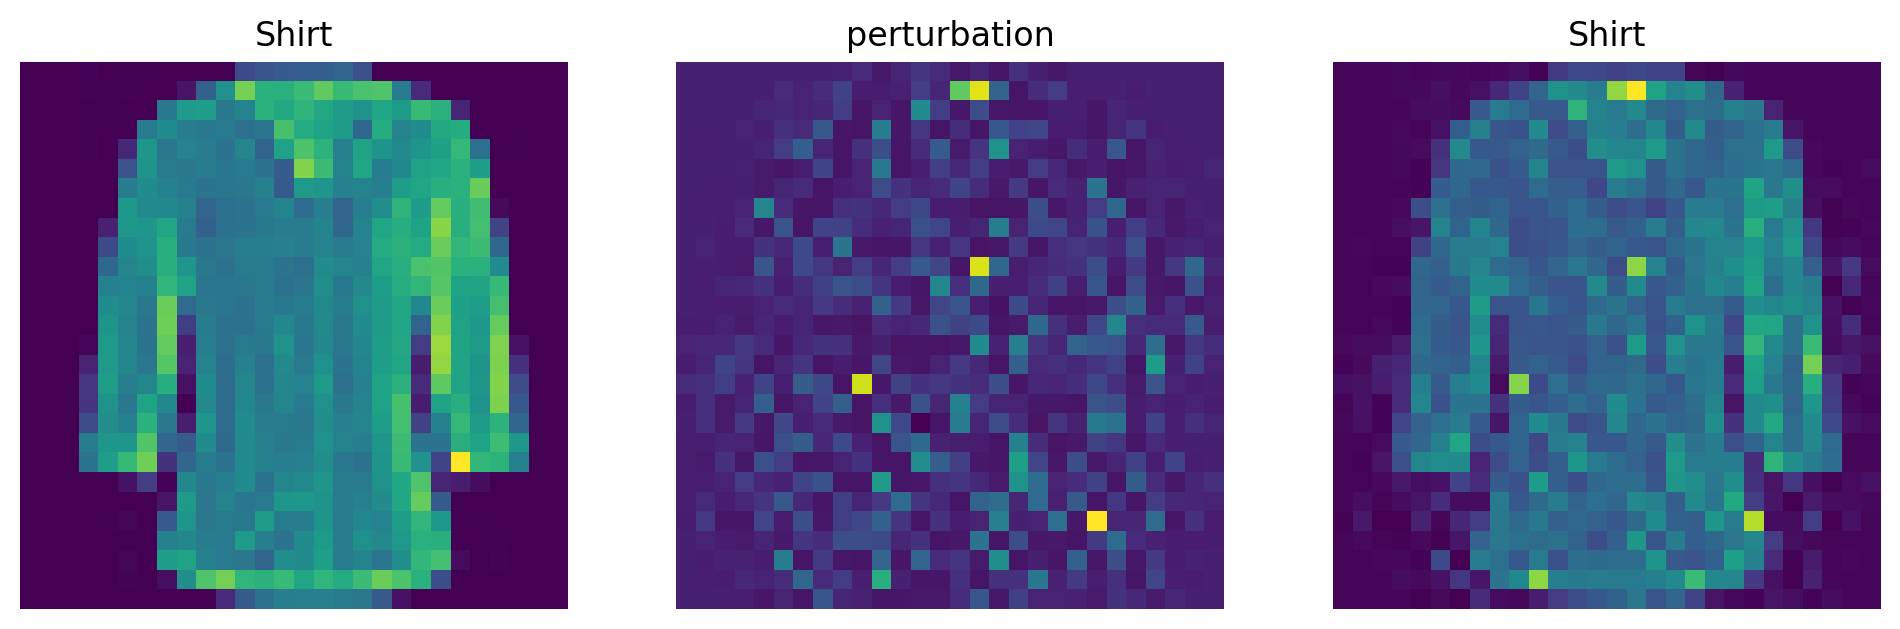

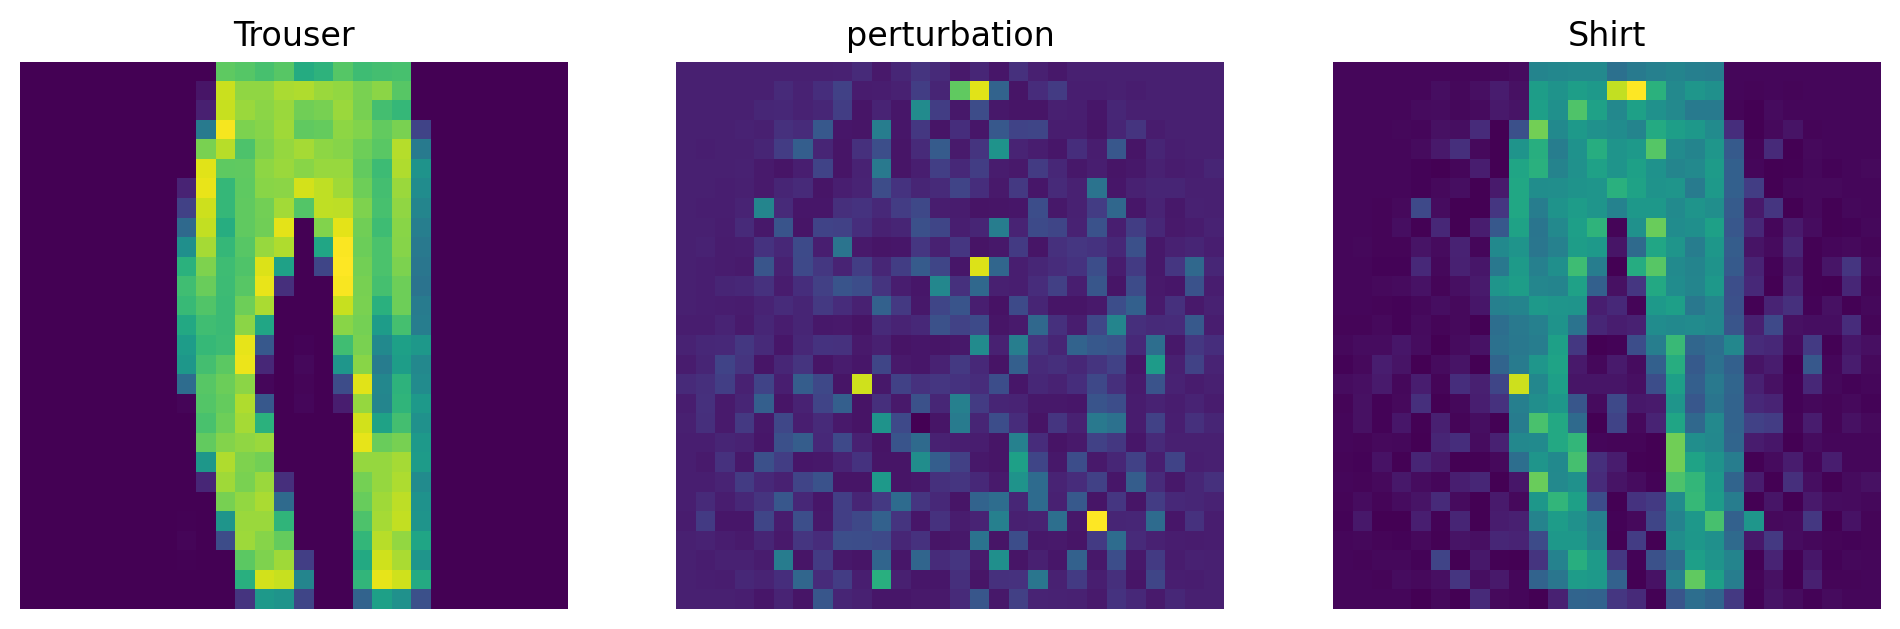

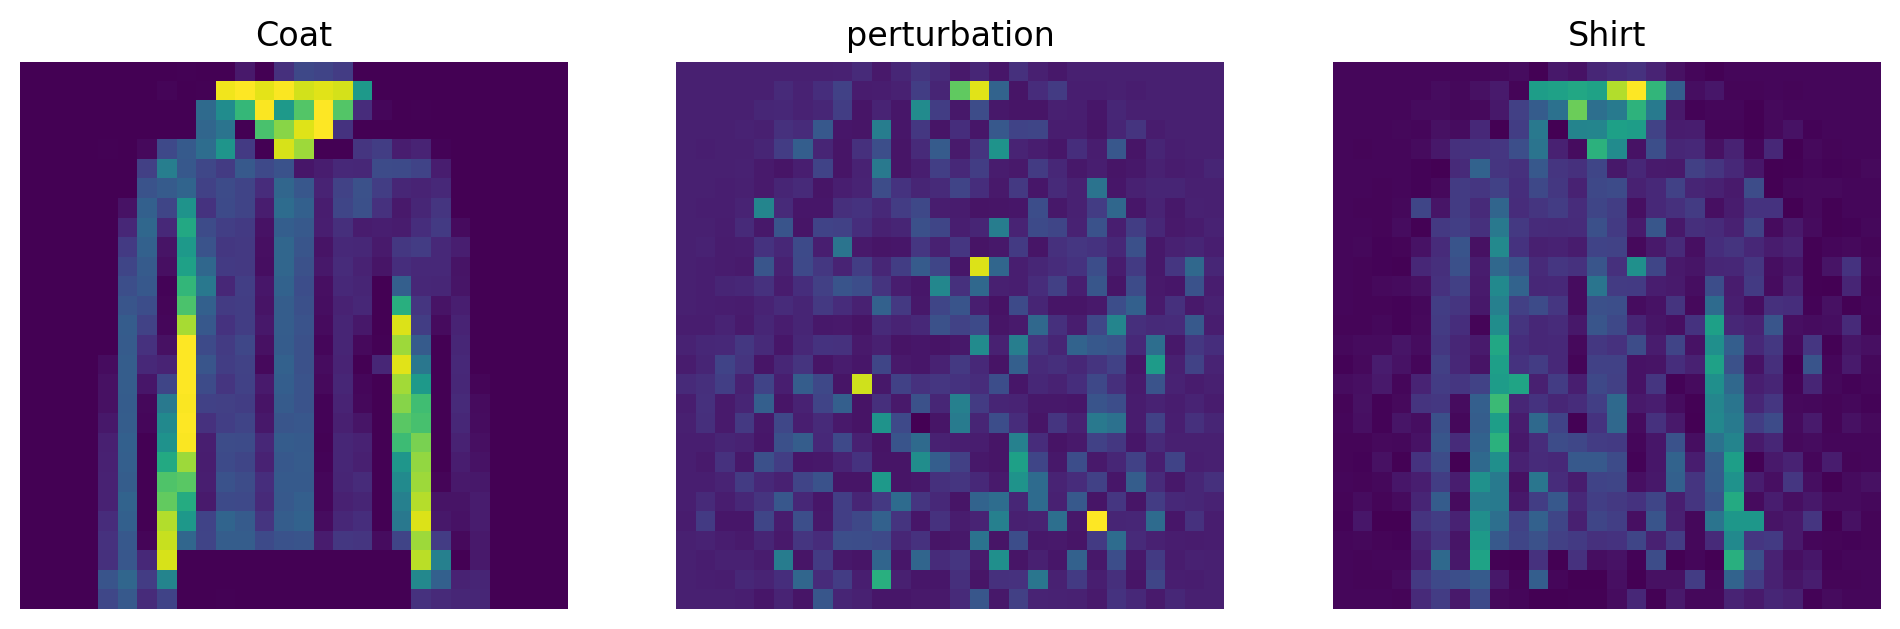

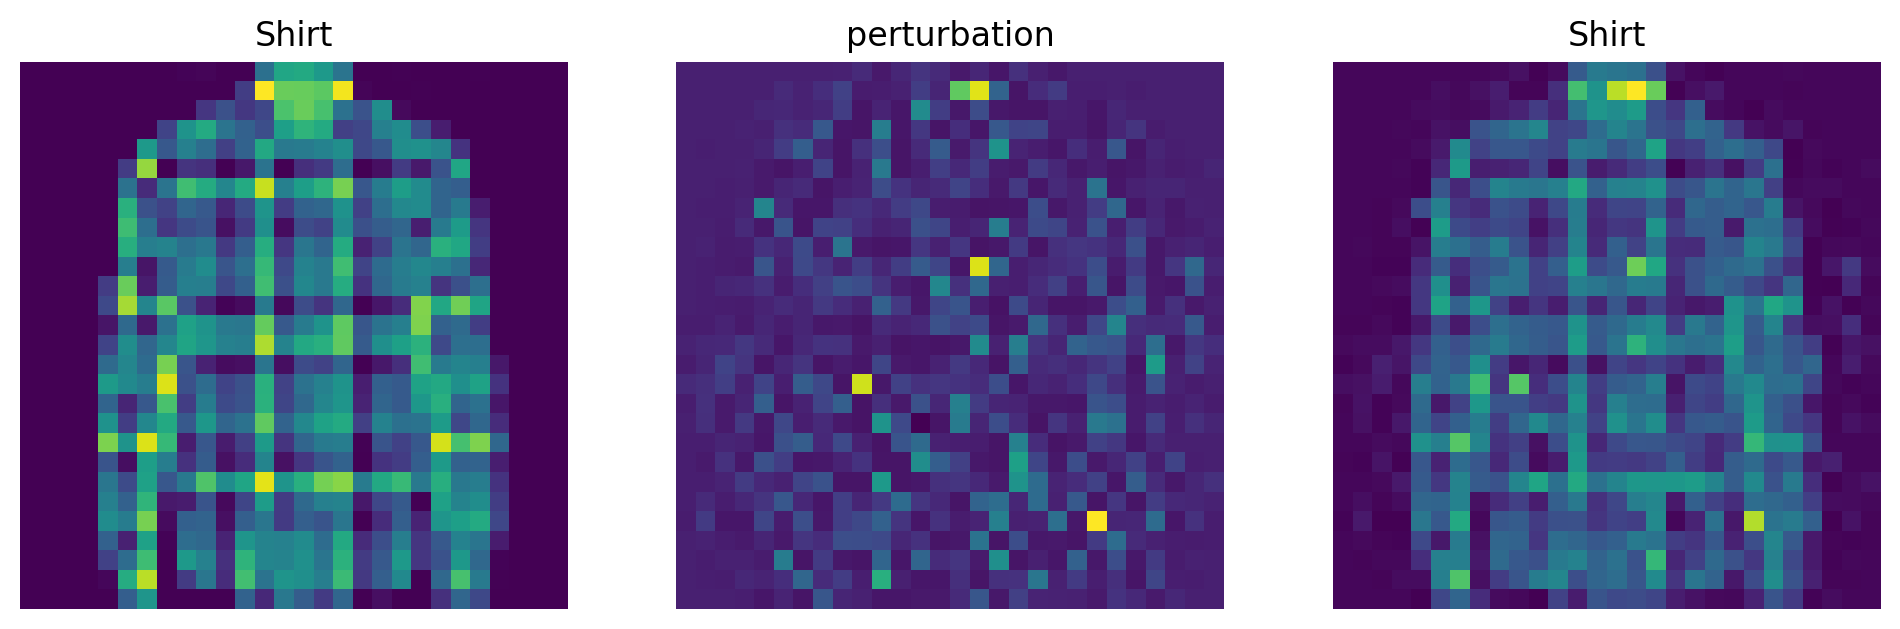

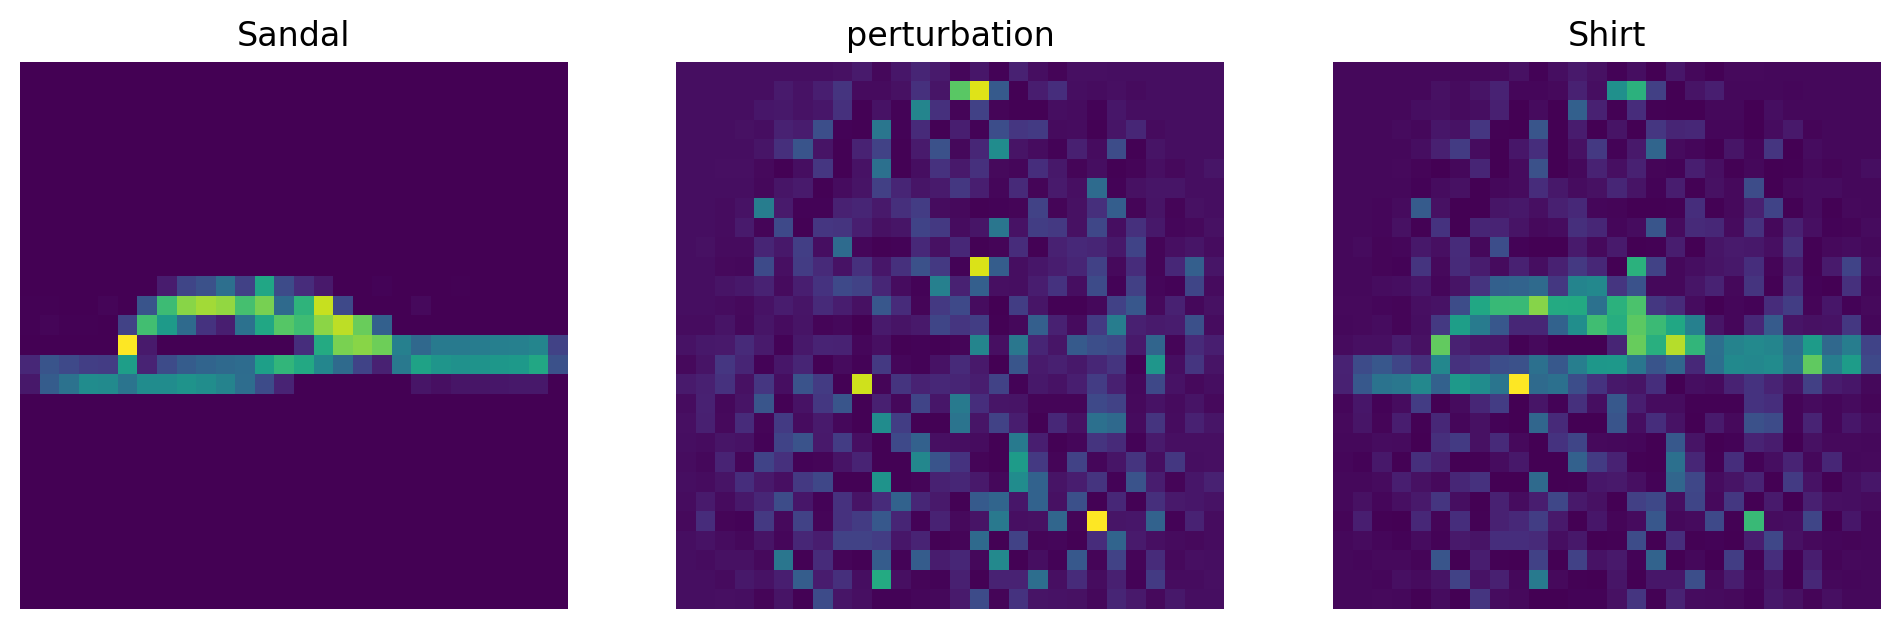

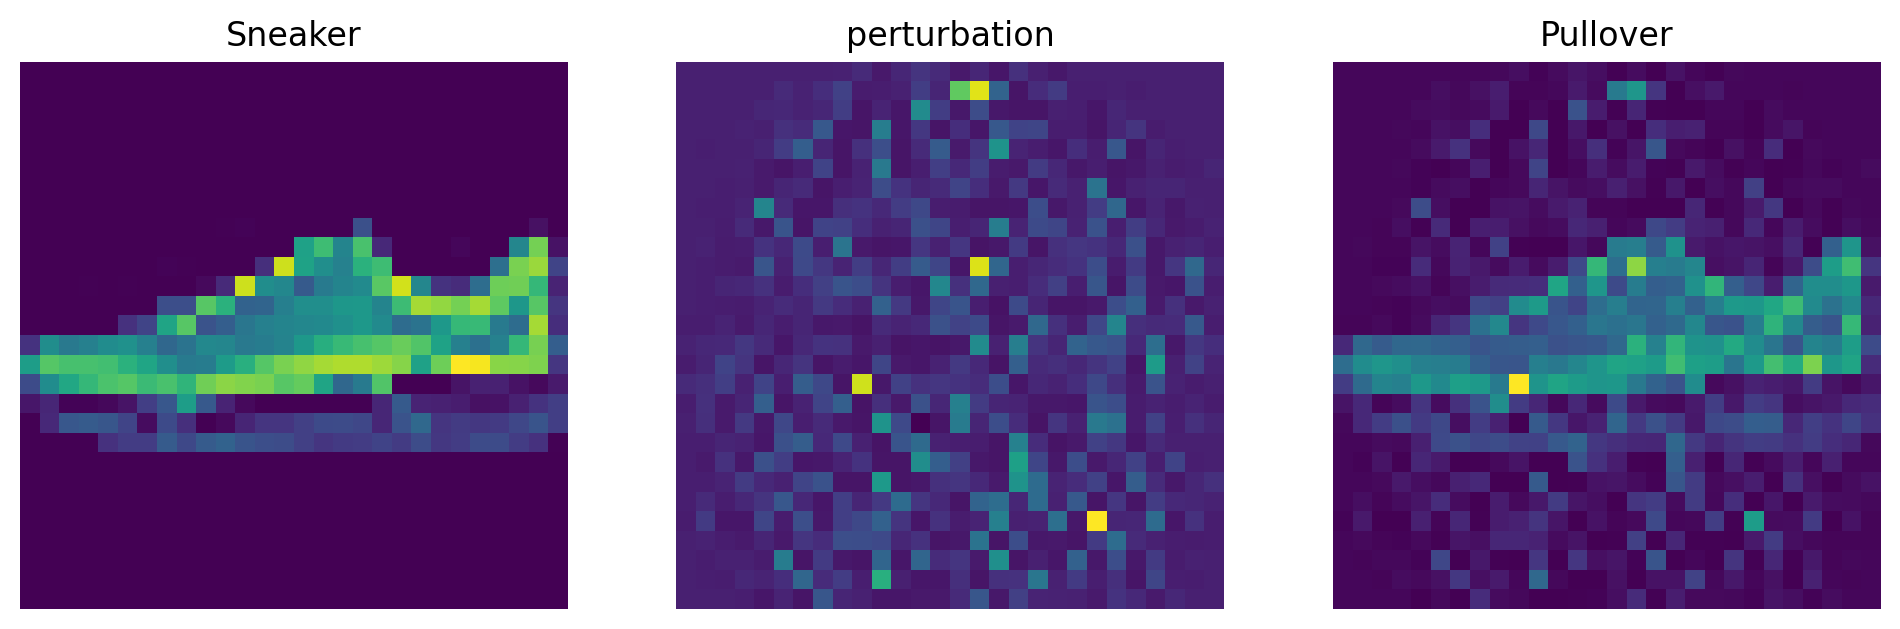

In [23]:
for i in range(10):
        original_image = test_x[i]
        pertubed_image = x_test_attack[i]
        
        image_figure, image_axes = plt.subplots(1, 3, figsize=( 12, 4))
        
        #original image
        ax = image_axes[0]
        ax.imshow(original_image[0])
        ax.grid(False); ax.axis('off'); ax.set_title(labels_map[test_y[i].item()])
        
        # get the perturbation (difference between original image and perturbed image)
        perturbation = pertubed_image[0] - original_image[0]
        ax = image_axes[1]
        ax.imshow(perturbation)
        ax.grid(False); ax.axis('off'); ax.set_title('perturbation')

        # perturbed image
        ax = image_axes[2]
        ax.imshow(pertubed_image[0])
        ax.grid(False); ax.axis('off'); ax.set_title(labels_map[predictions[i].argmax().item()].split(',')[0])

We see that we have identified a common/universal perturbation that casues missclassification of different images

<h3> A different architecture - ResNet

In [24]:
# model taken from https://colab.research.google.com/github/kjamithash/Pytorch_DeepLearning_Experiments/blob/master/FashionMNIST_ResNet_TransferLearning.ipynb#scrollTo=EauNKxXsSznF

class MnistResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(MnistResNet, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)

<h2> Model training

In [25]:
# model:
model_resnet = MnistResNet().to(device)

# params you need to specify:
epochs = 5
batch_size = 50

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=3e-4) # Using Karpathy's learning rate constant

losses = []
batches = len(fashion_train_dataloader)
val_batches = len(fashion_test_dataloader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(fashion_train_dataloader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model_resnet.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model_resnet.zero_grad()
        outputs = model_resnet(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    val_losses = 0
    accuracy = []
    
    # set model to evaluating (testing)
    model_resnet.eval()
    with torch.no_grad():
        for i, data in enumerate(fashion_test_dataloader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model_resnet(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            accuracy.append(accuracy_score(y.cpu(), predicted_classes.cpu()))
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    
    losses.append(total_loss/batches) # for plotting learning curve

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loss: 0.4405: 100%|██████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.60it/s]


Epoch 1/5, training loss: 0.44054784764846167, validation loss: 0.3398555815219879


Loss: 0.2951: 100%|██████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.62it/s]


Epoch 2/5, training loss: 0.2950751761098703, validation loss: 0.2888934016227722


Loss: 0.2438: 100%|██████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.59it/s]


Epoch 3/5, training loss: 0.24377174379924932, validation loss: 0.2652398943901062


Loss: 0.2139: 100%|██████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.63it/s]


Epoch 4/5, training loss: 0.21386414242287477, validation loss: 0.27412256598472595


Loss: 0.1891: 100%|██████████████████████████████████████████████████████████████████| 600/600 [00:38<00:00, 15.41it/s]


Epoch 5/5, training loss: 0.18911573628584544, validation loss: 0.2651135325431824


In [26]:
actuals, predictions = test_label_predictions(model_resnet, device, fashion_test_dataloader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[863   0  21  23   8   0  82   0   3   0]
 [  2 985   0  12   0   0   0   0   1   0]
 [ 11   0 845   9  65   0  69   0   1   0]
 [ 17   4  16 947  10   0   5   0   1   0]
 [  0   1  68  50 823   0  58   0   0   0]
 [  0   0   0   0   0 986   0   9   0   5]
 [ 98   1  48  35  72   0 735   0  11   0]
 [  0   0   0   0   0  20   0 920   0  60]
 [  1   1   2   6   3   0   4   2 981   0]
 [  1   0   0   0   0   5   0  15   0 979]]
Accuracy score: 0.906400


In [27]:
# repeat the attack from above
# create a PyTorchClassifier from our network
art_model = PyTorchClassifier(model=model_resnet, loss=criterion, optimizer=optimizer, channels_first=True, input_shape=(1,28,28,), nb_classes=10, clip_values=(0,255))
# create a universal perturbation
attack = UniversalPerturbation(classifier=art_model, attacker = "carlini")
# create attacked images
x_train_attack = attack.generate(train_x)
x_test_attack = attack.generate(test_x)

# predictions of attacked images
predictions = art_model.predict(x_test_attack)

# get the single predicted labels
predicted_labels = np.array([np.argmax(pred) for pred in predictions])

print('Base model accuracy: ', np.sum(predicted_labels == test_y) / len(test_y))

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Base model accuracy:  0.22


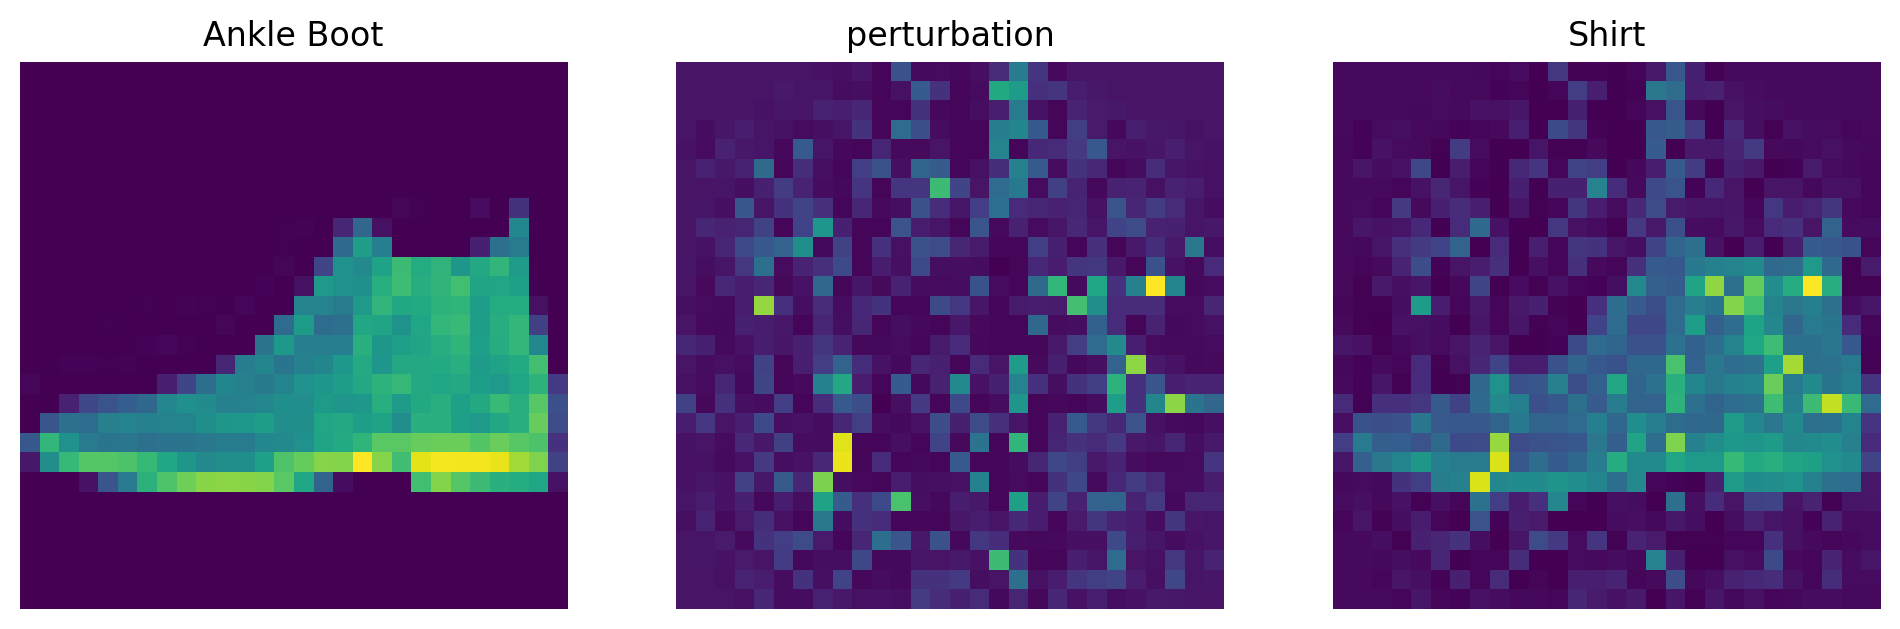

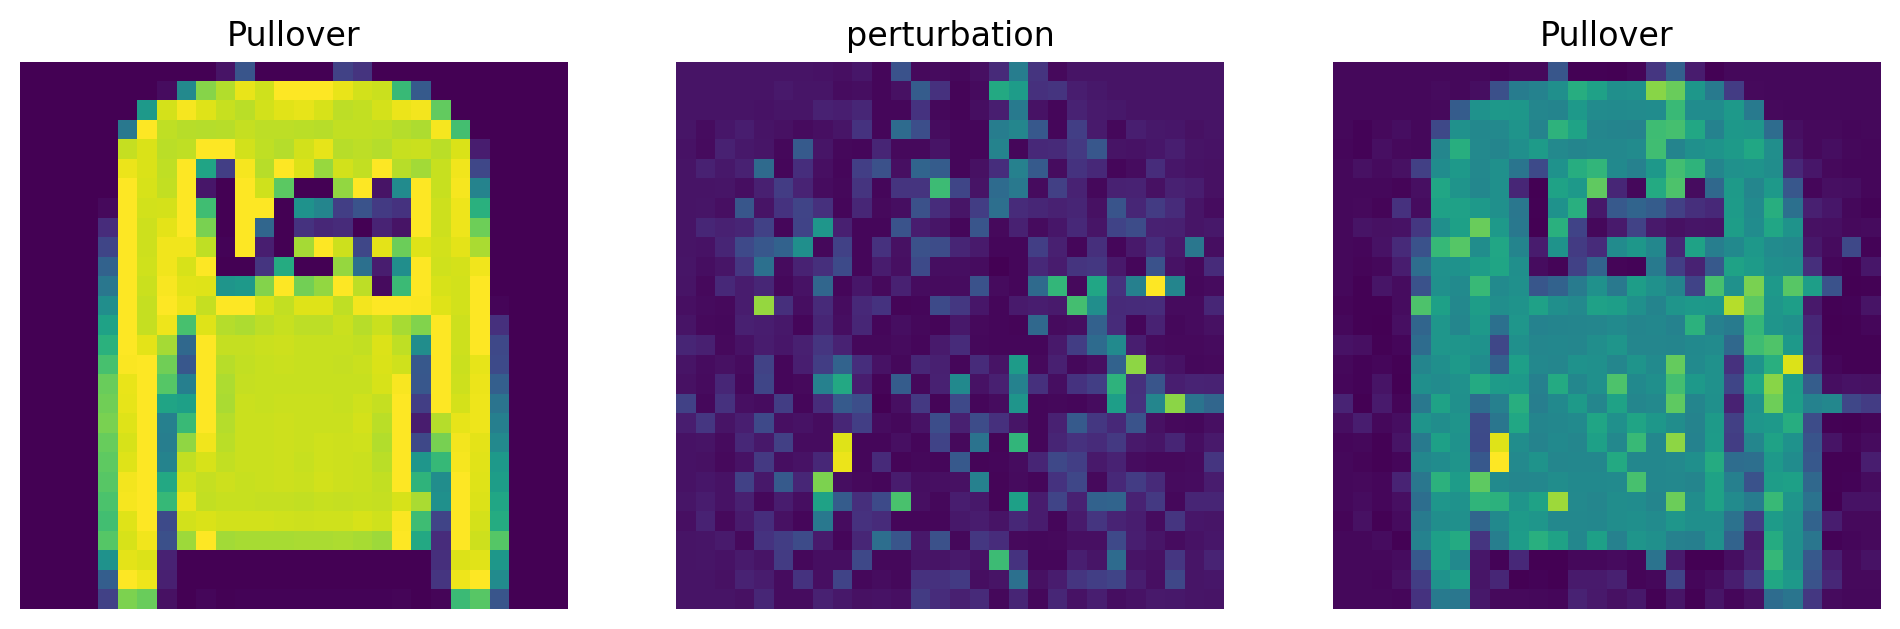

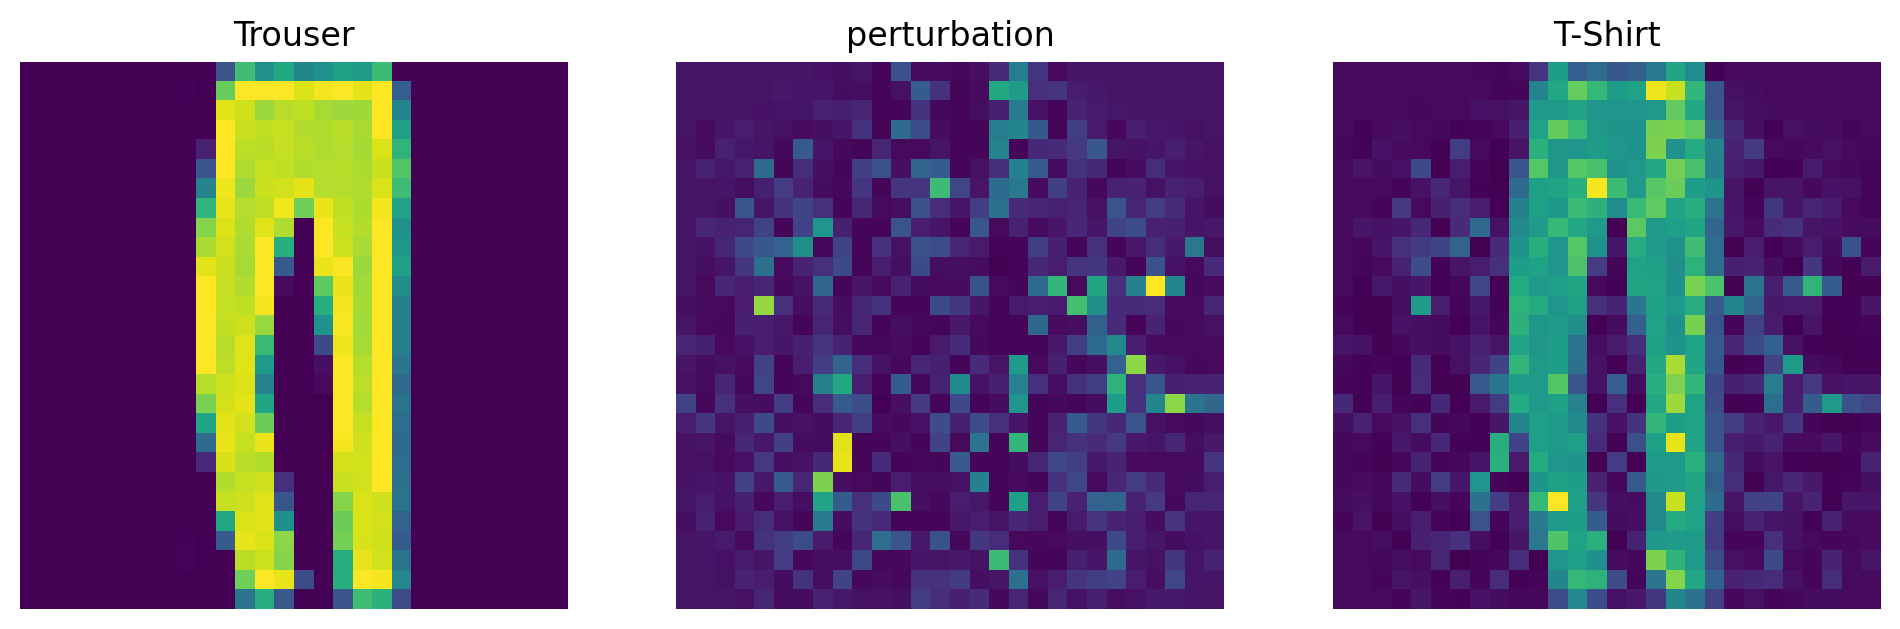

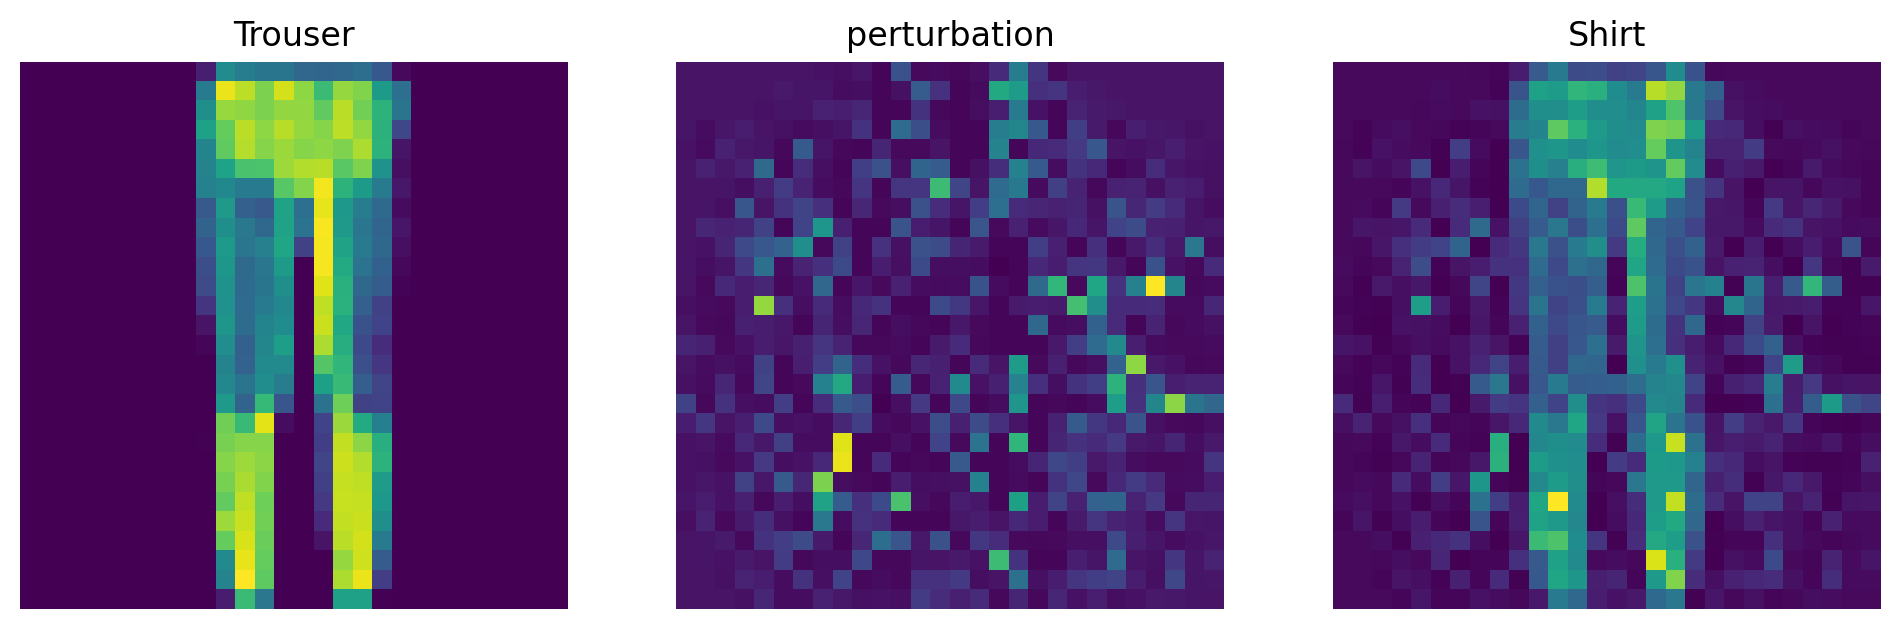

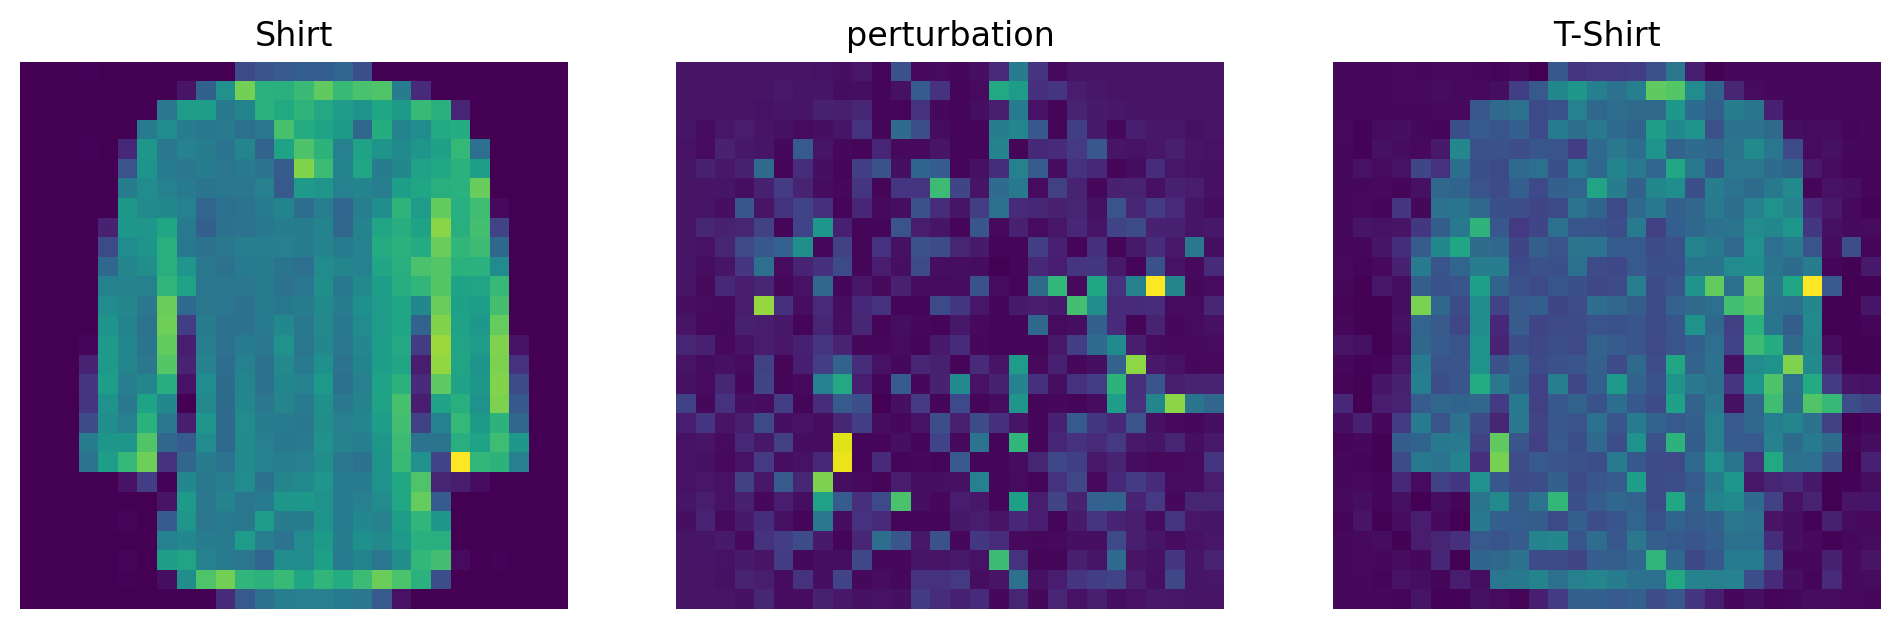

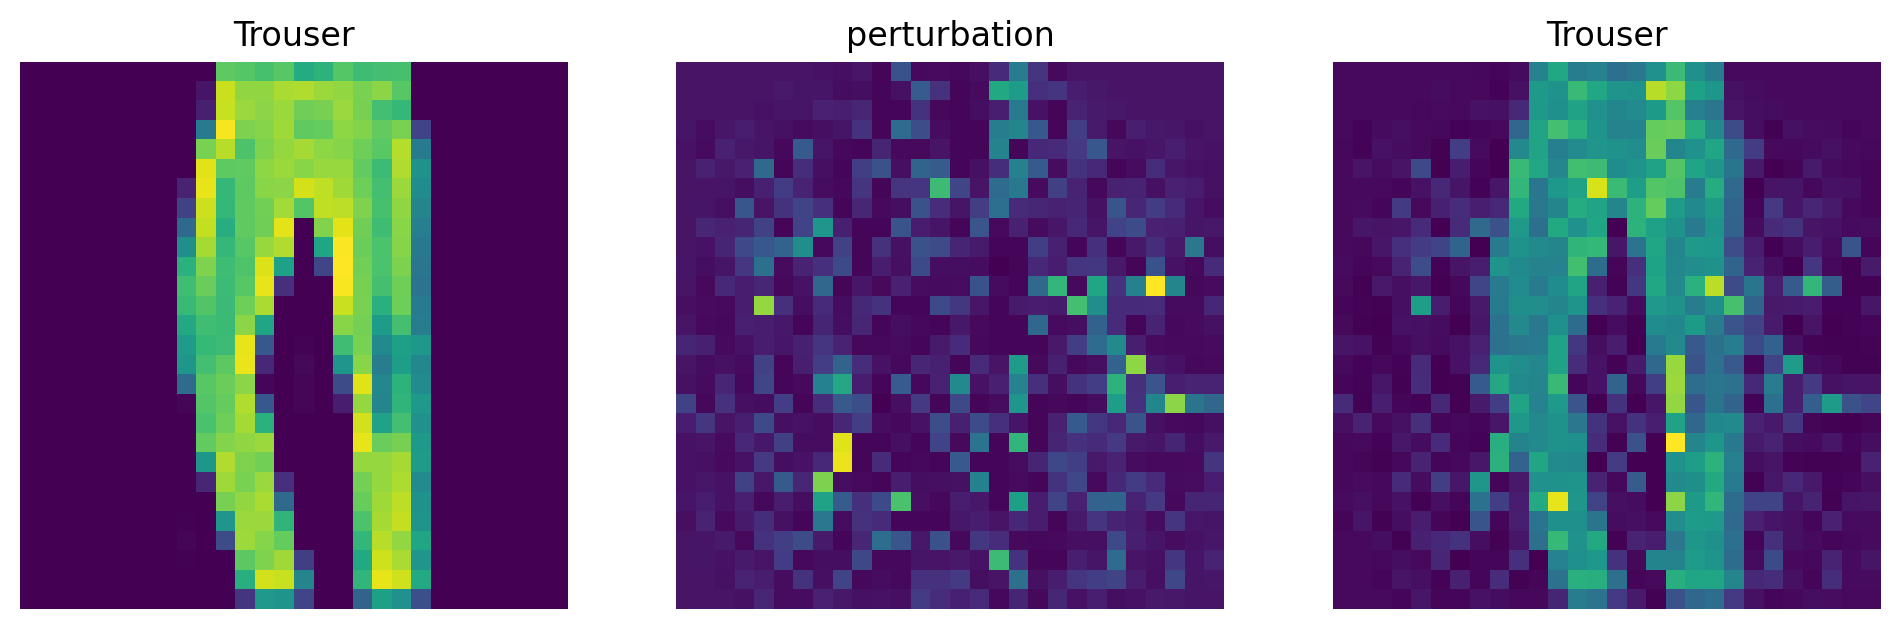

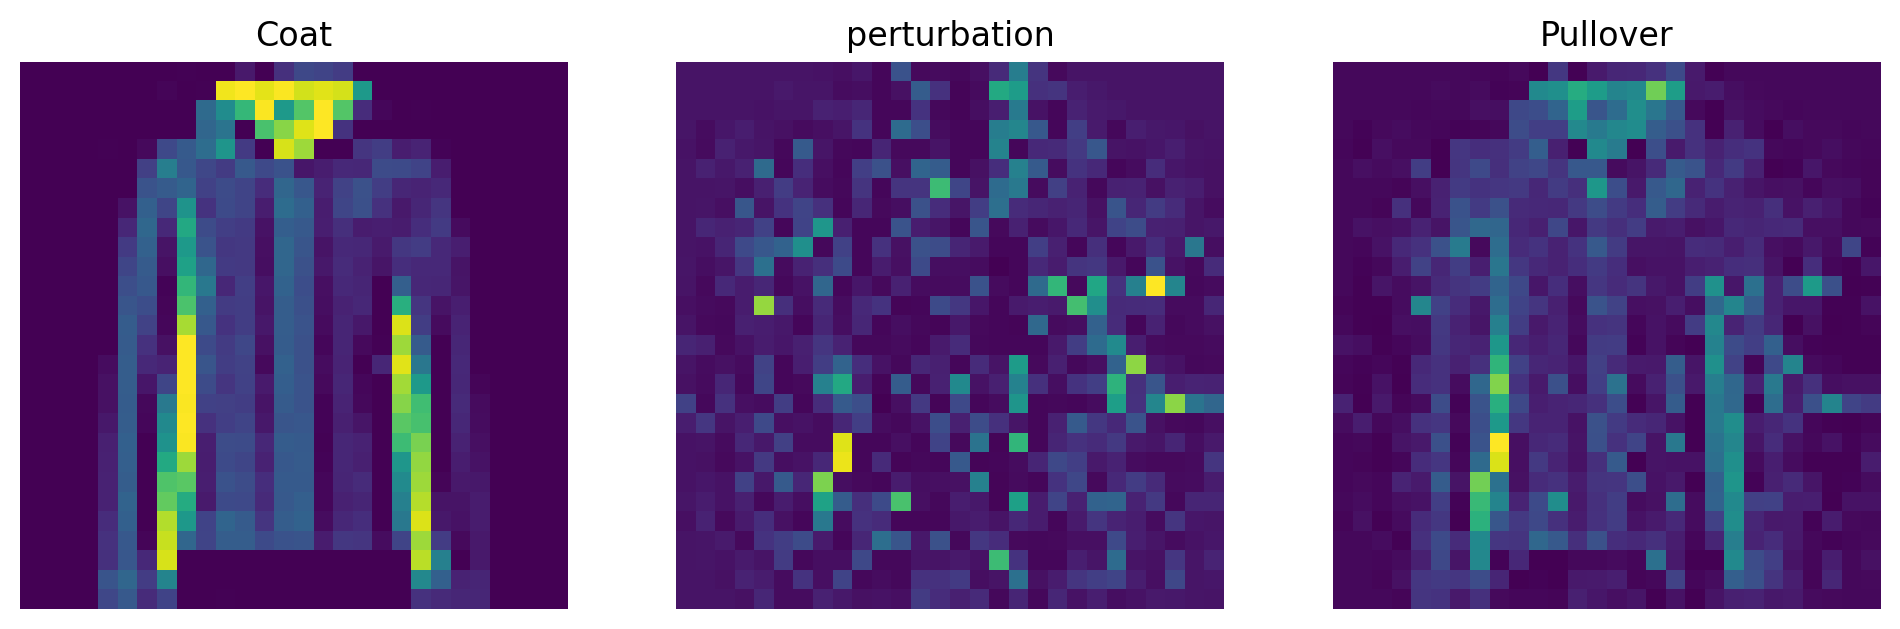

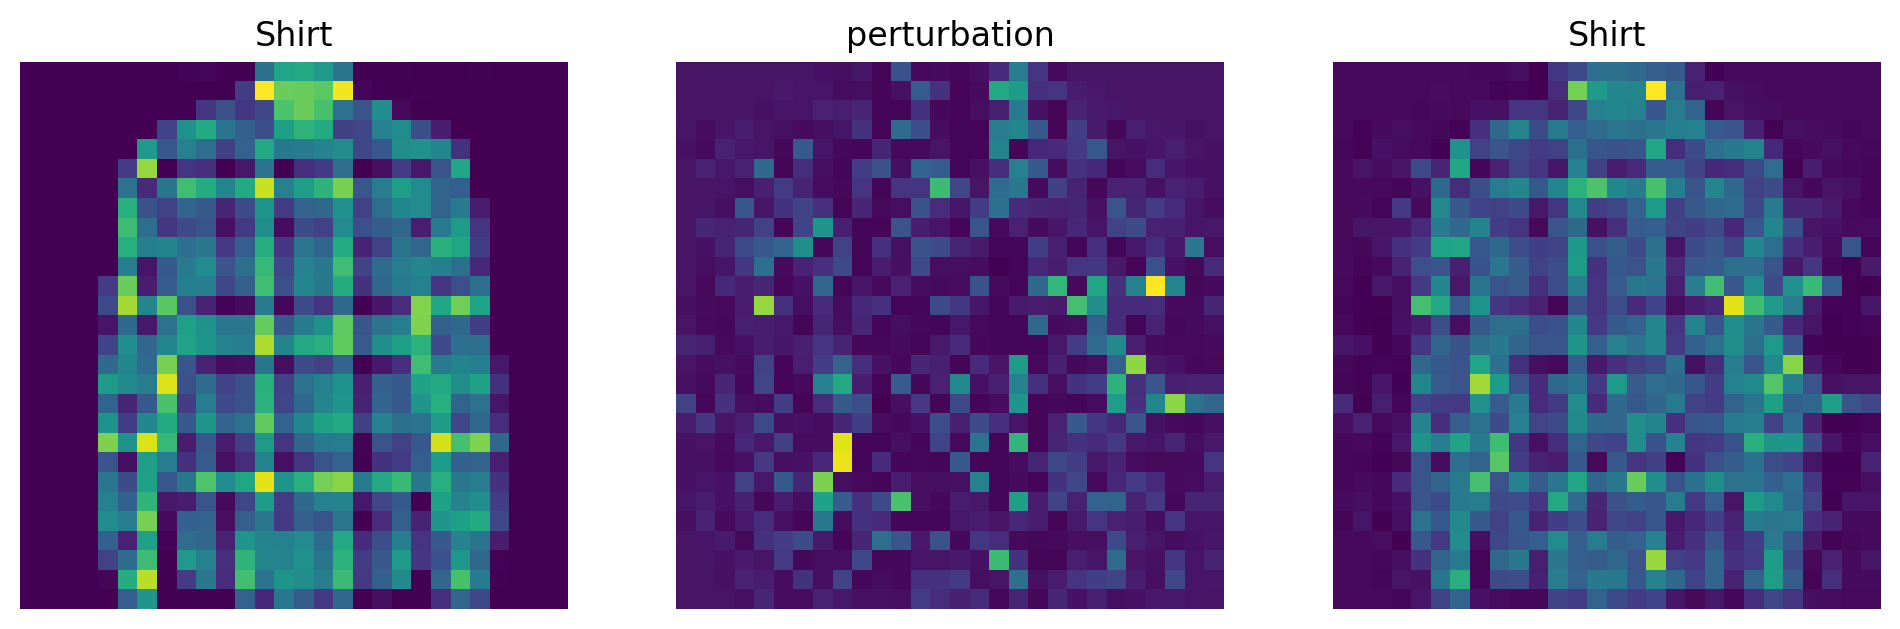

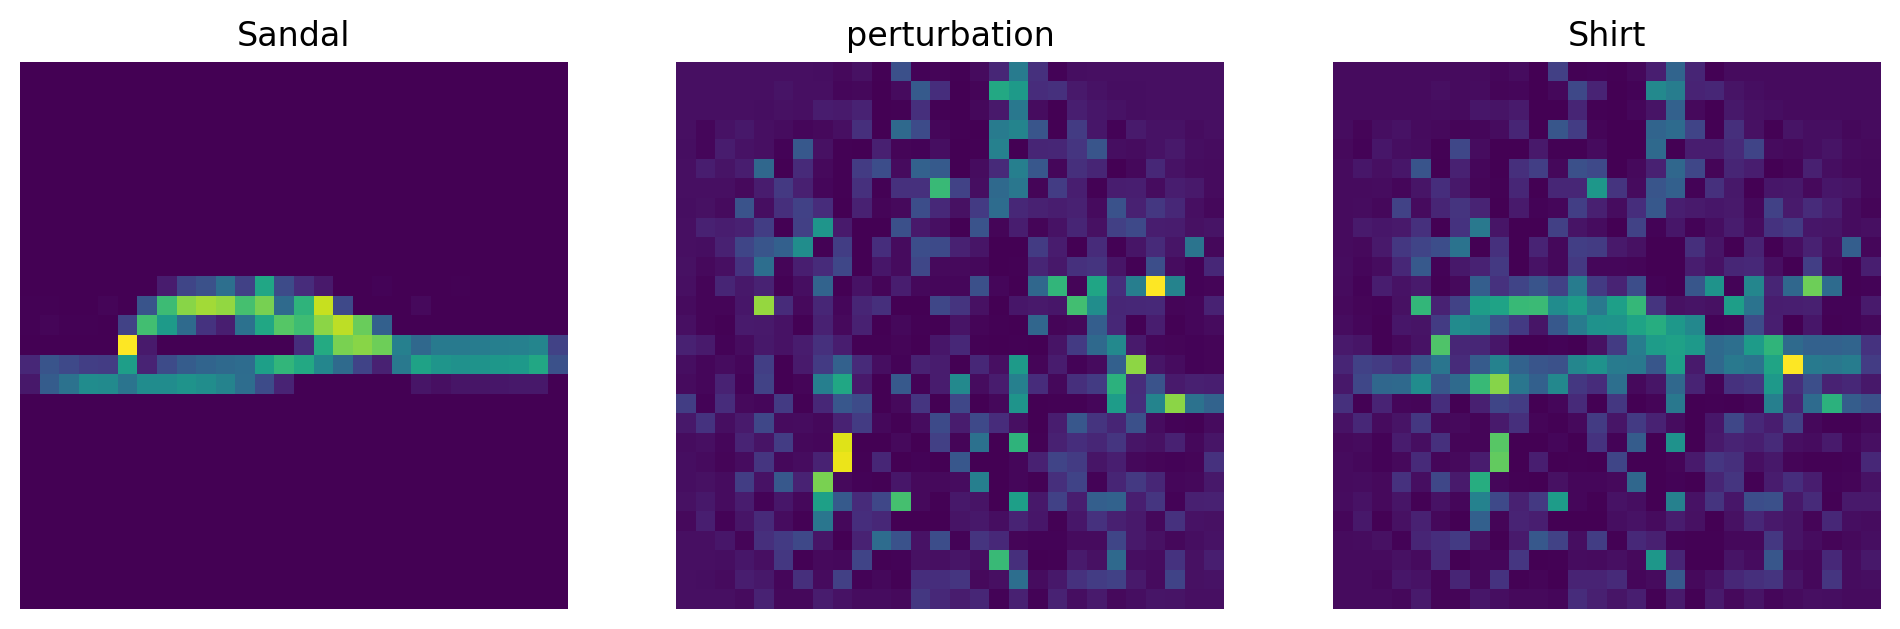

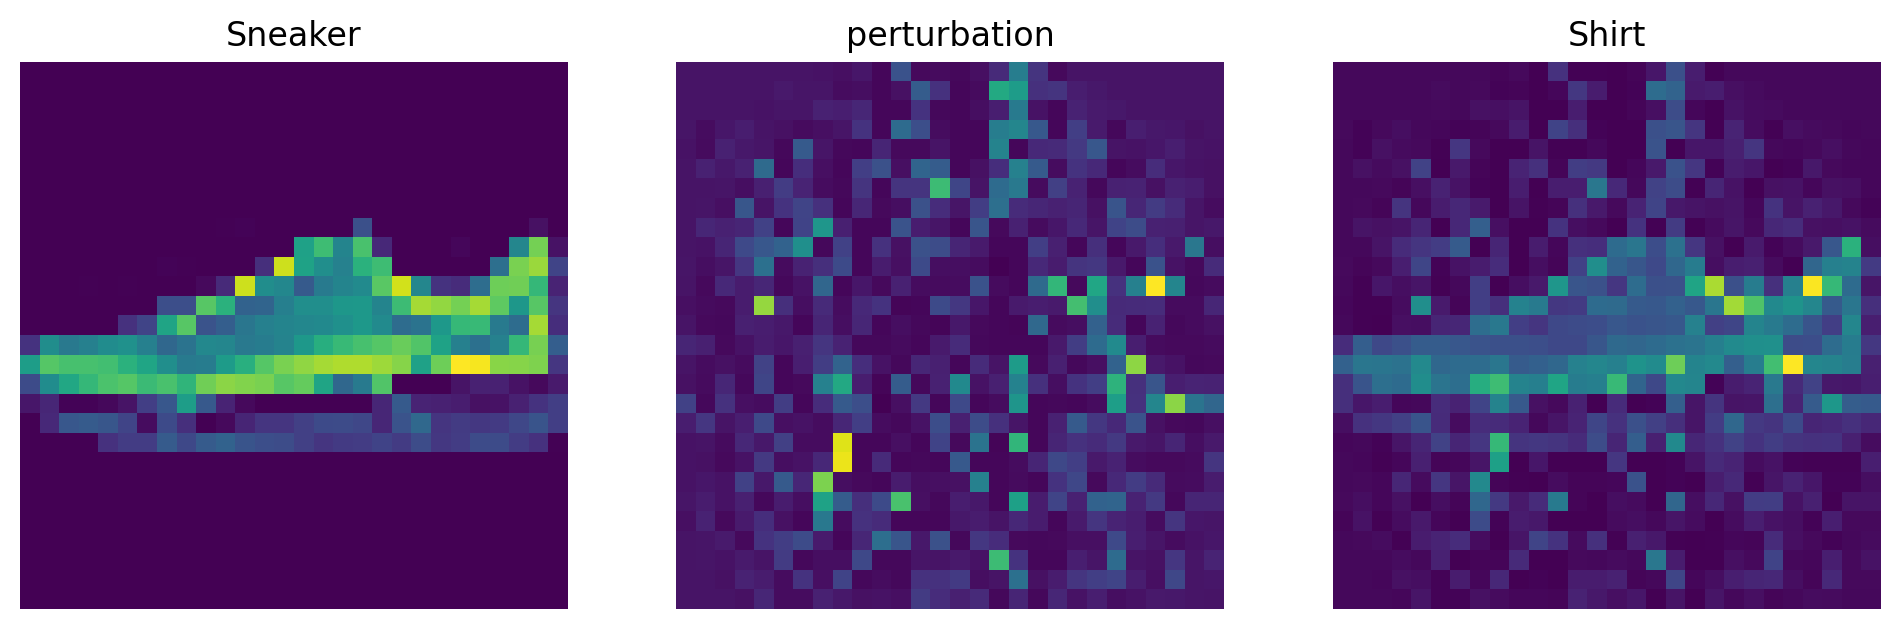

In [29]:
for i in range(10):
        original_image = test_x[i]
        pertubed_image = x_test_attack[i]
        
        image_figure, image_axes = plt.subplots(1, 3, figsize=( 12, 4))
        
        #original image
        ax = image_axes[0]
        ax.imshow(original_image[0])
        ax.grid(False); ax.axis('off'); ax.set_title(labels_map[test_y[i].item()])
        
        # get the perturbation (difference between original image and perturbed image)
        perturbation = pertubed_image[0] - original_image[0]
        ax = image_axes[1]
        ax.imshow(perturbation)
        ax.grid(False); ax.axis('off'); ax.set_title('perturbation')

        # perturbed image
        ax = image_axes[2]
        ax.imshow(pertubed_image[0])
        ax.grid(False); ax.axis('off'); ax.set_title(labels_map[predictions[i].argmax().item()].split(',')[0])